In [451]:
#RUN THE NIRS Event Conversion SCRIPT in the Beh notebook WHEN NEW SUBJECTS HAVE BEEN ADDED

#general dependencies (importing premade packages/libraries)
import numpy as np
import pandas as pd
import mne
import os
from glob import glob
from itertools import compress
from tqdm import tqdm

In [452]:
from platform import python_version
python_version()

'3.7.5'

In [453]:
import pycwt as wavelet
from pycwt.helpers import find

In [454]:
import io
from copy import copy
from collections import OrderedDict
import requests

In [455]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [457]:
# LCBD dependencies
# add relative path to our toolbox
import sys
sys.path.append('../../../..')
from LCBDtools.src import argParser
from LCBDtools.src import Plots

In [458]:
# Some configuration variables
study_dir = "/data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU"
participant_num_len = 4 # default length of participant numbers
ex_subs = [] # any subjects to not include in the dataset
debug = True

# set block durations (original data has start and stop data points, those stop data points are eventually removed to replace with durations instead, they are easier to work with)
durations = {
    'Block 1': 120,
    'Block 2': 105,
    'Block 3': 120}

In [459]:
# set the channels for each ROI
ROIs = {
    'Left Dorsolateral Prefrontal': ['S3_D2 hbo', 'S4_D2 hbo'],
    'Right Dorsolateral Prefrontal': ['S5_D3 hbo', 'S6_D3 hbo'],
    'Left Ventrolateral Prefrontal': ['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo'],
    'Right Ventrolateral Prefrontal': ['S7_D3 hbo', 'S7_D4 hbo', 'S8_D4 hbo']}

In [460]:
# make a list of all matching session paths (in this case for V0, assuming there should be more sessions?)
session_dirs = [d for d in glob(study_dir+"/*/*DB-DOS/*") \
    if os.path.basename(os.path.split(os.path.split(d)[1])[1]) not in ex_subs]

subjects = list(set([os.path.basename(d)[:participant_num_len] for d in session_dirs]))

In [461]:
session_dirs

['/data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1225/1225_DB-DOS/1225-P_fNIRS_DB-DOS',
 '/data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1225/1225_DB-DOS/1225-C_fNIRS_DB-DOS',
 '/data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1252/1252_DB-DOS/1252-C_fNIRS_DB-DOS',
 '/data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1252/1252_DB-DOS/1252-P_fNIRS_DB-DOS',
 '/data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1258/1258_DB-DOS/1258-P_fNIRS_DB-DOS',
 '/data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1258/1258_DB-DOS/1258-C_fNIRS_DB-DOS',
 '/data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1151/1151_DB-DOS/1151-C_fNIRS_DB-DOS',
 '/data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1151/1151_DB-DOS/1151-P_fNIRS_DB-DOS',
 '/data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1126/1126_DB-DOS/1126-C_fNIRS_DB-DOS',
 '/data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1126/1126_DB-DOS/1126-P_fNIRS

In [462]:
len(session_dirs)

244

In [463]:
len(session_dirs)/2

122.0

In [493]:
# make a list where all of the scans will get loaded into (for children and for parent)
scans = []
successful_load = []

# loop over all the session directories (dyads / DB-DOS folders)
for dyad_dir in list(set([os.path.split(ses)[0] for ses in session_dirs])):
    try:
        # get subject and visit from this path
        sub = os.path.basename(os.path.dirname(dyad_dir))
        if debug:
            print(sub)
        
        # determining whether sub is Child or Parent can be done by reading the config file in the .nirx directory        
        config_files = glob(os.path.join(dyad_dir, "*DB-DOS", "*config*")) # 

        # open the file and read the line with Subject= in it
        for config in config_files:
            with open(config, 'r') as f:
                line = f.readline()
                while "Subject=" not in line:
                    line = f.readline()
                line = line.strip()
                line = line.replace("Subject=", "")
                
                # if the line is 1 it's the child
                if line == "1":
                    sub1 = os.path.dirname(config) # child
                elif line == "2":
                    sub2 = os.path.dirname(config) # parent
        
        # make sure it has 'modern' .evt files
        evts = glob(sub1 + "/*.evt")
        if len(evts) != 2:
            print("There should be 2 evt files. Skipping:", os.path.basename(sub1))
            continue
        print("Subject 1: ", sub1)
#         #**load each in via hypyp loader (fixing config file so that even if child and parent numbers were flipped, they will now each be labelled as c or p in object)**
        fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
        fnirs_participant_1.info['subject_info']['his_id'] = f"{sub[:participant_num_len]}c"
        
        fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
        fnirs_participant_2.info['subject_info']['his_id'] = f"{sub[:participant_num_len]}p"
        
        scans.append((fnirs_participant_1, fnirs_participant_2))
        successful_load.append(sub)
    # If anything fails with loading subject, skip   
    except:
        print("skipping session:", dyad_dir)
        continue

1267
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1267/1267_DB-DOS/1267-C_fNIRS_DB-DOS
1177
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1177/1177_DB-DOS/1177-C_fNIRS_DB-DOS
1118
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1118/1118_DB-DOS/1118-C_fNIRS_DB-DOS
1239
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1239/1239_DB-DOS/1239-C_fNIRS_DB-DOS
1117
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1117/1117_DB-DOS/1117-C_fNIRS_DB-DOS
1225
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1225/1225_DB-DOS/1225-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat f

1258
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1258/1258_DB-DOS/1258-C_fNIRS_DB-DOS
1222
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1222/1222_DB-DOS/1222-C_fNIRS_DB-DOS
1144
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1144/1144_DB-DOS/1144-C_fNIRS_DB-DOS
1134
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1134/1134_DB-DOS/1134-C_fNIRS_DB-DOS
1103
There should be 2 evt files. Skipping: 1103-C_fNIRS_DB-DOS
1102
There should be 2 evt files. Skipping: 1102-C_fNIRS_DB-DOS
1160
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1160/1160_DB-DOS/1160-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat f

1205
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1205/1205_DB-DOS/1205-C_fNIRS_DB-DOS
1250
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1250/1250_DB-DOS/1250-C_fNIRS_DB-DOS
1145
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1145/1145_DB-DOS/1145-C_fNIRS_DB-DOS
1154
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1154/1154_DB-DOS/1154-C_fNIRS_DB-DOS
1248
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1248/1248_DB-DOS/1248-C_fNIRS_DB-DOS
1184
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1184/1184_DB-DOS/1184-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat f

1247
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1247/1247_DB-DOS/1247-C_fNIRS_DB-DOS
1264
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1264/1264_DB-DOS/1264-C_fNIRS_DB-DOS
1204
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1204/1204_DB-DOS/1204-C_fNIRS_DB-DOS
1236
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1236/1236_DB-DOS/1236-C_fNIRS_DB-DOS
1168
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1168/1168_DB-DOS/1168-C_fNIRS_DB-DOS
1141
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1141/1141_DB-DOS/1141-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file w

1112
There should be 2 evt files. Skipping: 1112-C_fNIRS_DB-DOS
1138
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1138/1138_DB-DOS/1138-C_fNIRS_DB-DOS
1162
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1162/1162_DB-DOS/1162-C_fNIRS_DB-DOS
1178
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1178/1178_DB-DOS/1178-C_fNIRS_DB-DOS
1223
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1223/1223_DB-DOS/1223-C_fNIRS_DB-DOS
1115
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1115/1115_DB-DOS/1115-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat f

1238
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1238/1238_DB-DOS/1238-C_fNIRS_DB-DOS
1126
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1126/1126_DB-DOS/1126-C_fNIRS_DB-DOS
1231
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1231/1231_DB-DOS/1231-C_fNIRS_DB-DOS
1188
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1188/1188_DB-DOS/1188-C_fNIRS_DB-DOS
1213
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1213/1213_DB-DOS/1213-C_fNIRS_DB-DOS
1176
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1176/1176_DB-DOS/1176-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: Omitted 15 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: Omitted 15 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=Fal

1142
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1142/1142_DB-DOS/1142-C_fNIRS_DB-DOS
1186
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1186/1186_DB-DOS/1186-C_fNIRS_DB-DOS
1202
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1202/1202_DB-DOS/1202-C_fNIRS_DB-DOS
1130
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1130/1130_DB-DOS/1130-C_fNIRS_DB-DOS
1249
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1249/1249_DB-DOS/1249-C_fNIRS_DB-DOS
1131
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1131/1131_DB-DOS/1131-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: Omitted 8 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: Omitted 8 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False

1266
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1266/1266_DB-DOS/1266-C_fNIRS_DB-DOS
1268
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1268/1268_DB-DOS/1268-C_fNIRS_DB-DOS
1125
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1125/1125_DB-DOS/1125-C_fNIRS_DB-DOS
1220
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1220/1220_DB-DOS/1220-C_fNIRS_DB-DOS
1148
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1148/1148_DB-DOS/1148-C_fNIRS_DB-DOS
1253
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1253/1253_DB-DOS/1253-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat f

1127
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1127/1127_DB-DOS/1127-C_fNIRS_DB-DOS
1200
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1200/1200_DB-DOS/1200-C_fNIRS_DB-DOS
1179
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1179/1179_DB-DOS/1179-C_fNIRS_DB-DOS
1116
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1116/1116_DB-DOS/1116-C_fNIRS_DB-DOS
1122
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1122/1122_DB-DOS/1122-C_fNIRS_DB-DOS
1244
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1244/1244_DB-DOS/1244-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file w

1189
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1189/1189_DB-DOS/1189-C_fNIRS_DB-DOS
1246
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1246/1246_DB-DOS/1246-C_fNIRS_DB-DOS
1214
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1214/1214_DB-DOS/1214-C_fNIRS_DB-DOS
1143
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1143/1143_DB-DOS/1143-C_fNIRS_DB-DOS
1219
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1219/1219_DB-DOS/1219-C_fNIRS_DB-DOS
1234
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1234/1234_DB-DOS/1234-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file w

1251
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1251/1251_DB-DOS/1251-C_fNIRS_DB-DOS
1193
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1193/1193_DB-DOS/1193-C_fNIRS_DB-DOS
1109
There should be 2 evt files. Skipping: 1109-C_fNIRS_DB-DOS
1139
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1139/1139_DB-DOS/1139-C_fNIRS_DB-DOS
1242
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1242/1242_DB-DOS/1242-C_fNIRS_DB-DOS
1129
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1129/1129_DB-DOS/1129-C_fNIRS_DB-DOS
1255
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1255/1255_DB-DOS/1255-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file w

1147
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1147/1147_DB-DOS/1147-C_fNIRS_DB-DOS
1185
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1185/1185_DB-DOS/1185-C_fNIRS_DB-DOS
1151
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1151/1151_DB-DOS/1151-C_fNIRS_DB-DOS
1149
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1149/1149_DB-DOS/1149-C_fNIRS_DB-DOS
1159
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1159/1159_DB-DOS/1159-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat f

1110
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1110/1110_DB-DOS/1110-C_fNIRS_DB-DOS
1164
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1164/1164_DB-DOS/1164-C_fNIRS_DB-DOS
1216
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1216/1216_DB-DOS/1216-C_fNIRS_DB-DOS
1137
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1137/1137_DB-DOS/1137-C_fNIRS_DB-DOS
1235
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1235/1235_DB-DOS/1235-C_fNIRS_DB-DOS
1265
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1265/1265_DB-DOS/1265-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file w

1226
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1226/1226_DB-DOS/1226-C_fNIRS_DB-DOS
1243
There should be 2 evt files. Skipping: 1243-C_fNIRS_DB-DOS
1121
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1121/1121_DB-DOS/1121-C_fNIRS_DB-DOS
1240
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1240/1240_DB-DOS/1240-C_fNIRS_DB-DOS
1170
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1170/1170_DB-DOS/1170-C_fNIRS_DB-DOS
1146
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1146/1146_DB-DOS/1146-C_fNIRS_DB-DOS
1195
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1195/1195_DB-DOS/1195-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat f

1228
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1228/1228_DB-DOS/1228-C_fNIRS_DB-DOS
1194
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1194/1194_DB-DOS/1194-C_fNIRS_DB-DOS
1133
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1133/1133_DB-DOS/1133-C_fNIRS_DB-DOS
1263
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1263/1263_DB-DOS/1263-C_fNIRS_DB-DOS
1254
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1254/1254_DB-DOS/1254-C_fNIRS_DB-DOS
1113
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1113/1113_DB-DOS/1113-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file w

1180
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1180/1180_DB-DOS/1180-C_fNIRS_DB-DOS
1190
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1190/1190_DB-DOS/1190-C_fNIRS_DB-DOS
1182
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1182/1182_DB-DOS/1182-C_fNIRS_DB-DOS
1221
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1221/1221_DB-DOS/1221-C_fNIRS_DB-DOS
1270
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1270/1270_DB-DOS/1270-C_fNIRS_DB-DOS
1203


/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file w

Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1203/1203_DB-DOS/1203-C_fNIRS_DB-DOS
1211
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1211/1211_DB-DOS/1211-C_fNIRS_DB-DOS
1124
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1124/1124_DB-DOS/1124-C_fNIRS_DB-DOS
1175
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1175/1175_DB-DOS/1175-C_fNIRS_DB-DOS
1114
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1114/1114_DB-DOS/1114-C_fNIRS_DB-DOS
1174
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1174/1174_DB-DOS/1174-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat f

1232
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1232/1232_DB-DOS/1232-C_fNIRS_DB-DOS
1252
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1252/1252_DB-DOS/1252-C_fNIRS_DB-DOS
1155
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1155/1155_DB-DOS/1155-C_fNIRS_DB-DOS
1104
There should be 2 evt files. Skipping: 1104-C_fNIRS_DB-DOS
1173
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1173/1173_DB-DOS/1173-C_fNIRS_DB-DOS
1245
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1245/1245_DB-DOS/1245-C_fNIRS_DB-DOS
1227
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1227/1227_DB-DOS/1227-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file w

1156
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1156/1156_DB-DOS/1156-C_fNIRS_DB-DOS
1165
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1165/1165_DB-DOS/1165-C_fNIRS_DB-DOS
1207
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1207/1207_DB-DOS/1207-C_fNIRS_DB-DOS
1209
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1209/1209_DB-DOS/1209-C_fNIRS_DB-DOS
1187
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1187/1187_DB-DOS/1187-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat f

1237
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1237/1237_DB-DOS/1237-C_fNIRS_DB-DOS
1119
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1119/1119_DB-DOS/1119-C_fNIRS_DB-DOS
1167
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1167/1167_DB-DOS/1167-C_fNIRS_DB-DOS
1172
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1172/1172_DB-DOS/1172-C_fNIRS_DB-DOS
1269
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1269/1269_DB-DOS/1269-C_fNIRS_DB-DOS
1256
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1256/1256_DB-DOS/1256-C_fNIRS_DB-DOS
1229
Subject 1:  /data/perlman/moochie/analysis/P-CAT/NIRS_Data_Clean_WU_PSU/1229/1229_DB-DOS/1229-C_fNIRS_DB-DOS


/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_12243/1331186643.py:38: RuntimeWarning: A single dat file was expected in the specified path, but got 2. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 + '/', preload=False, verbose="warning") # child
/tmp/ipykernel_12243/1331186643.py:41: RuntimeWarning: A single dat f

In [494]:
len(scans)

116

In [495]:
#raw NIRS data for child and parent now loaded into "scans" object
scans

[(<RawNIRX | 1267-C_fNIRS_DB-DOS, 20 x 15719 (2011.9 s), ~31 kB, data not loaded>,
  <RawNIRX | 1267-P_fNIRS_DB-DOS, 20 x 15719 (2011.9 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1177-C_fNIRS_DB-DOS, 20 x 15913 (2036.7 s), ~31 kB, data not loaded>,
  <RawNIRX | 1177-P_fNIRS_DB-DOS, 20 x 15913 (2036.7 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1118-C_fNIRS_DB-DOS, 20 x 9021 (1154.6 s), ~31 kB, data not loaded>,
  <RawNIRX | 1118-P_fNIRS_DB-DOS, 20 x 9021 (1154.6 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1239-C_fNIRS_DB-DOS, 20 x 9996 (1279.4 s), ~31 kB, data not loaded>,
  <RawNIRX | 1239-P_fNIRS_DB-DOS, 20 x 9996 (1279.4 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1117-C_fNIRS_DB-DOS, 20 x 14889 (1905.7 s), ~31 kB, data not loaded>,
  <RawNIRX | 1117-P_fNIRS_DB-DOS, 20 x 14889 (1905.7 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1225-C_fNIRS_DB-DOS, 20 x 15432 (1975.2 s), ~31 kB, data not loaded>,
  <RawNIRX | 1225-P_fNIRS_DB-DOS, 20 x 15432 (1975.2 s), ~31 kB, data not loaded>),
 (

In [496]:
#Listing subjects that were missing 2 EVT files
failed_load = []
soi = os.listdir('../../../../../analysis/P-CAT/NIRS_Data_Clean_WU_PSU')
for subject in soi:
    if subject not in successful_load:
        failed_load.append(subject)
        
failed_load

['1104', '1109', '1103', '1112', '1102', '1243']

In [497]:
X = scans[0][0].get_data()

In [498]:
scans[0][0].get_data()

array([[0.4613921, 0.4569626, 0.4607557, ..., 0.5334988, 0.5323889,
        0.5353167],
       [0.5134658, 0.5072823, 0.511248 , ..., 0.5894102, 0.5867541,
        0.5905713],
       [0.1889202, 0.1889037, 0.1896454, ..., 0.294493 , 0.2944341,
        0.2955068],
       ...,
       [0.8306926, 0.8366642, 0.8466489, ..., 1.1035233, 1.1062837,
        1.1134866],
       [0.5127828, 0.5156838, 0.5202326, ..., 0.8953277, 0.9011727,
        0.9033561],
       [1.2097512, 1.2199682, 1.2336092, ..., 2.0812183, 2.0893538,
        2.1028592]])

In [499]:
scans[0][0].get_data().shape

(20, 15719)

In [500]:
t = scans[0][0].times

In [501]:
scans[26][0].times

array([0.000000e+00, 1.280000e-01, 2.560000e-01, ..., 1.929984e+03,
       1.930112e+03, 1.930240e+03])

In [502]:
scans[0][0].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

In [503]:
plt.plot(
    t,
    X[10]
)

In [504]:
#can use to check the subject info for each member of dyad in the scans object. First number selects dyad pair, 2nd number: 0 = child, 1 = parent
scans[115][0].info['subject_info']

{'his_id': '1229c',
 'first_name': '1229-C',
 'sex': 1 (FIFFV_SUBJ_SEX_MALE),
 'birthday': (2018, 6, 13)}

In [505]:
#Checking annotation before running script to remove the stop annotations
scans[0][0].annotations

<Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>

In [506]:
#if annotations don't match across subjects, need to check the evt files for consistency, run a event conversion script for the data
for scan in scans:
    print(scan[0].info['subject_info']['his_id'],scan[0].annotations)


1267c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1177c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1118c <Annotations | 12 segments: 1.0 (4), 128.0 (6), 2.0 (2)>
1239c <Annotations | 16 segments: 1.0 (4), 128.0 (8), 2.0 (4)>
1117c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1225c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1258c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1222c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1144c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1134c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1160c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1205c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1250c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1145c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)

In [507]:
# rename events and set durations for block 1 and 2

# if we can't load in the annotations right, we'll remove them from our list of scans
bads = []

for i, dscan in enumerate(scans):
    
    try:
        for scan in dscan:

            # rename the binary annotations with actual names
            scan.annotations.rename({
                '1.0': 'Block 1',
                '2.0': 'Block 2',
                '4.0': 'Block 3'})

            # remove any stop annotations
            scan.annotations.delete(scan.annotations.description == '128.0')

            # set the durations based off the durations dictionary
            scan.annotations.set_durations(durations, verbose=True)
    
    except:
        bads.append(i)
        
for i in sorted(bads, reverse=True):
    del scans[i]

In [508]:
scans[0][0].annotations

<Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>

In [509]:
#Check to confirm that annotations are now consistent across subjects
for scan in scans:
    print(scan[0].info['subject_info']['his_id'],scan[0].annotations)

1267c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1177c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1117c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1225c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1258c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1222c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1144c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1134c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1160c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1205c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1250c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1145c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1154c <Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>
1248c <Annotations | 12 segments: Block 1 (4), Bloc

In [510]:
#This will let you know how many subjects could have their psychopy annotatations standardized
len(scans)

108

In [511]:
scans

[(<RawNIRX | 1267-C_fNIRS_DB-DOS, 20 x 15719 (2011.9 s), ~31 kB, data not loaded>,
  <RawNIRX | 1267-P_fNIRS_DB-DOS, 20 x 15719 (2011.9 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1177-C_fNIRS_DB-DOS, 20 x 15913 (2036.7 s), ~31 kB, data not loaded>,
  <RawNIRX | 1177-P_fNIRS_DB-DOS, 20 x 15913 (2036.7 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1117-C_fNIRS_DB-DOS, 20 x 14889 (1905.7 s), ~31 kB, data not loaded>,
  <RawNIRX | 1117-P_fNIRS_DB-DOS, 20 x 14889 (1905.7 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1225-C_fNIRS_DB-DOS, 20 x 15432 (1975.2 s), ~31 kB, data not loaded>,
  <RawNIRX | 1225-P_fNIRS_DB-DOS, 20 x 15432 (1975.2 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1258-C_fNIRS_DB-DOS, 20 x 14641 (1873.9 s), ~31 kB, data not loaded>,
  <RawNIRX | 1258-P_fNIRS_DB-DOS, 20 x 14641 (1873.9 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1222-C_fNIRS_DB-DOS, 20 x 14995 (1919.2 s), ~31 kB, data not loaded>,
  <RawNIRX | 1222-P_fNIRS_DB-DOS, 20 x 14995 (1919.2 s), ~31 kB, data not loaded>)

In [512]:
scans[1][0].annotations.to_data_frame()

,onset,duration,description
0,2022-10-17 10:58:45.025,120.0,Block 1
1,2022-10-17 11:00:58.785,120.0,Block 1
2,2022-10-17 11:03:12.417,120.0,Block 1
3,2022-10-17 11:05:26.177,120.0,Block 1
4,2022-10-17 11:14:29.537,105.0,Block 2
5,2022-10-17 11:16:28.065,105.0,Block 2
6,2022-10-17 11:18:26.593,105.0,Block 2
7,2022-10-17 11:20:25.249,105.0,Block 2
8,2022-10-17 11:23:32.641,120.0,Block 3
9,2022-10-17 11:25:46.273,120.0,Block 3


In [513]:
from typing import Union

# function to do Continuous Wavelet Transform on a single signal
#Sig1: raw MNE converted signal or Epoch; plot = set whether you want to plot the wavelet (True or False); chs: produce a wavelet for a specific channel
def mne_wavelet_transform(sig1: [mne.io.Raw, mne.Epochs], plot: bool = True,
                      chs: Union[str] = None):
    """
    Perform a continuous wavelet transform based off data in mne Raw object
    """
    
    #Fourier Transform "transforms" data from time to frequency domain (certain number of oscillations per second)
    #The the final wavelet transform is an intermediate between time and frequency domain, it just needs to be transformed to frquency first
    # set time ##t0 = start time and dt = distance in time from t0. N is length
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
    #t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters ## Clayton Add reference for parameters? (By default uses a Morlet convolution function to align detected signal with
    # with this base function) 
    #Video on Morlet wavelets
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
        
    #reshaping of signal
    for ch in chs:
        dat = np.squeeze(sig1.get_data(picks=[ch])) * 1e5
        
        # detrend and normalize the input data by its standard deviation (to remove drift effects)
        p = np.polyfit(t - t0, dat, 1)
        dat_notrend = dat - np.polyval(p, t - t0)
        std = dat_notrend.std() # standard deviation
        var = std ** 2 # variance
        dat_norm = dat_notrend / std # normalized dataset
        
        alpha, _, _ = wavelet.ar1(dat) # lag-1 autocorrelation for red noise
        
        #This is the actual function where dat_norm, dt etc. are entered to produce the wavelet tranformed matrix, weighted scales for each matrix, list of frequencies
        # coming from each matrix, the cone of influence (gives a prospective range in which signal should closely convolve with Morlet),
        #fast fourier transform? (fft)
        wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
            dat_norm, dt, dj, s0, J, mother)
        iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
    
        # plotting the fourier tranform
        power = (np.abs(wave)) ** 2
        fft_power = np.abs(fft) ** 2
        period = 1 / freqs
        power /= scales[:, None] # optional according to Liu et al. (2007)
        
        # power significance test (the degree of convergence of the signal and the Morlet function? Also compare frequencies in one epoch vs the other?)
        signif, fft_theor = wavelet.significance(
            1.0, dt, scales, 0, alpha,
            significance_level=0.95, 
            wavelet=mother)
        sig95 = np.ones([1, N]) * signif[:, None]
        sig95 = power / sig95
        
        # calculate global wavelet spectrum and determine its significance level
        glbl_power = power.mean(axis=1)
        dof = N - scales # correction for padding at edges
        glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                                significance_level=0.95, dof=dof,
                                                wavelet=mother)
        
        # calculate scale average and its significance level
        sel = find((period >= 5) & (period < 105))
        Cdelta = mother.cdelta
        scale_avg = (scales * np.ones((N, 1))).transpose()
        scale_avg = power / scale_avg # As in Torrence and Compo (1998) equation 24
        scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
        scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                                    significance_level=0.95,
                                                    dof=[scales[sel[0]],
                                                        scales[sel[-1]]],
                                                    wavelet=mother)
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} Channel {ch} Continuous Wavelet Transform"
            label = ""
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the original time series
            ax = plt.axes([0.1, 0.75, 0.65, 0.2])
            ax.plot(t, dat, 'k', linewidth=1.5)
            ax.set_title('a) {}'.format(title))
            ax.set_ylabel(r'{} [{}]'.format(label, units))
            
            # second sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
            levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            conmap = bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), 
                        extend='both', cmap=plt.cm.jet)
#             plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
            bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                                  extent=extent)
            bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
            bx.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            bx.set_yticks(np.log2(Yticks))
            bx.set_yticklabels(1/Yticks)
            
            # third sub-plot, the global wavelet and Fourier power spectra and theoretical
            # noise spectra. Note that period scale is logarithmic
            cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
            cx.plot(glbl_signif, np.log2(period), 'k--')
            cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
            cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
                    linewidth=1.)
            cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
            cx.set_title('c) Global Wavelet Spectrum')
            cx.set_xlabel(r'Power [({})^2]'.format(units))
            cx.set_xlim([0, glbl_power.max() + var])
            cx.set_ylim(np.log2([period.min(), period.max()]))
            cx.set_yticks(np.log2(Yticks))
            cx.set_yticklabels(1/Yticks)
            plt.setp(cx.get_yticklabels(), visible=False)
            
            # Fourth sub-plot, the scale averaged wavelet spectrum.
            dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
            dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
            dx.plot(t, scale_avg, 'k-', linewidth=1.5)
            dx.set_title('d) {}--{} second scale-averaged power'.format(2, 8))
            dx.set_xlabel('Time (seconds)')
            dx.set_ylabel(r'Average variance [{}]'.format(units))
            ax.set_xlim([t.min(), t.max()])

            plt.show()
    
    return wave, scales, freqs, coi, fft, fftfreqs


# function to do wavelet coherence transform on 2 signals
def mne_wavelet_coherence_transform(sig1: [mne.io.Raw, mne.Epochs],
        sig2: [mne.io.Raw, mne.Epochs],
        plot: bool = True, fig_fname: str = None,
        chs: Union[str] = None):
    
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
#     t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
        
    for ch in chs:
        dat1 = np.squeeze(sig1.get_data(picks=[ch]))
        dat2 = np.squeeze(sig2.get_data(picks=[ch]))
        
        if np.isnan(dat1).any():
            print("Dat 1 contains NaN values")
            raise ValueError
            
        if np.isnan(dat2).any():
            print("Dat 2 contains NaN values")
            raise ValueError
        
        # detrend and normalize the input data by its standard deviation
        p1 = np.polyfit(t - t0, dat1, 1)
        dat_notrend1 = dat1 - np.polyval(p1, t - t0)
        std1 = dat_notrend1.std() # standard deviation
        var1 = std1 ** 2 # variance
        dat_norm1 = dat_notrend1 / std1 # normalized dataset
        
        # detrend and normalize the input data by its standard deviation
        p2 = np.polyfit(t - t0, dat2, 1)
        dat_notrend2 = dat2 - np.polyval(p2, t - t0)
        std2 = dat_notrend2.std() # standard deviation
        var2 = std2 ** 2 # variance
        dat_norm2 = dat_notrend2 / std2 # normalized dataset
        
        WCT, aWCT, coi, freqs, sig95 = wavelet.wct(
            dat_norm1, dat_norm2,
            dt, dj=dj, s0=s0, J=J, sig=False,
            significance_level=0.95, wavelet='morlet',
            normalize=True)
        
        period = 1 / freqs
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} / {sig2.info['subject_info']['his_id']} Channel {ch} Wavelet Coherence Transform"
            label = f"{sig1.info['subject_info']['his_id']} {sig2.info['subject_info']['his_id']} {ch}"
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            ax = plt.axes([0.1, 0.37, 0.65, 0.28])
#             levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            levels = list(np.arange(0.1, 1, step=0.1))
            conmap = ax.contourf(t, np.log2(period), WCT, levels, 
                        extend='both', cmap=plt.cm.jet)
            plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
#             ax.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#                                   extent=extent)
            ax.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            ax.set_title('b) {} Wavelet Coherence Spectrum ({})'.format(label, mother.name))
            ax.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            ax.set_yticks(np.log2(Yticks))
            ax.set_yticklabels(1/Yticks)
            ax.set_xlim([t.min(), t.max()])
            ax.set_ylim(np.log2([period.min(), period.max()]))
            
            if fig_fname is None:
                plt.show()
            else:
                plt.savefig(fig_fname)
            
    return WCT, aWCT, coi, freqs, sig95 

In [514]:
#will be converted to HbO and HbR channels later in the script
scans[107][0].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

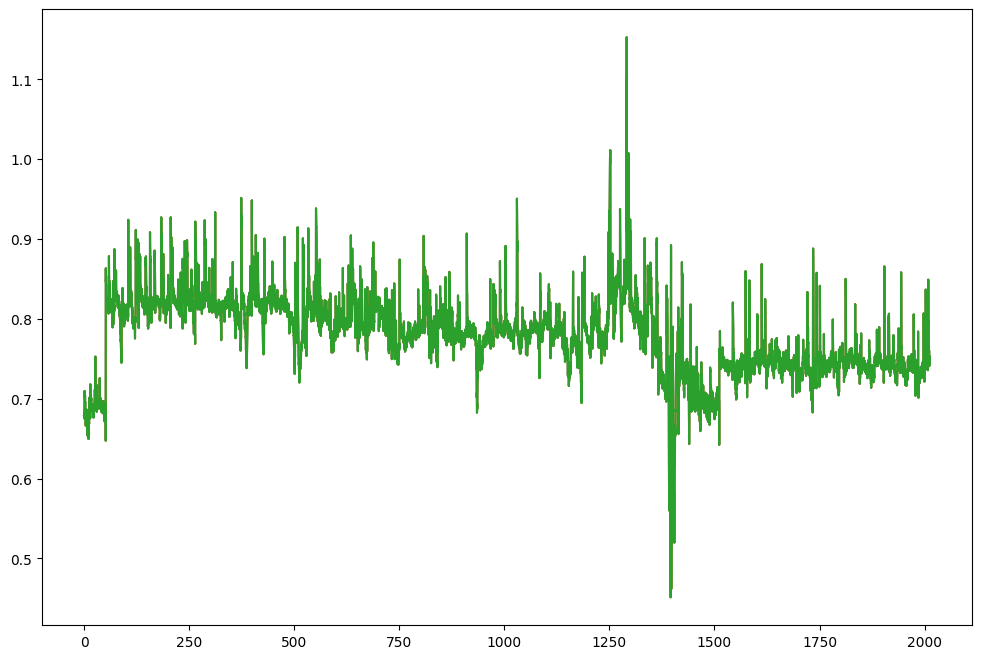

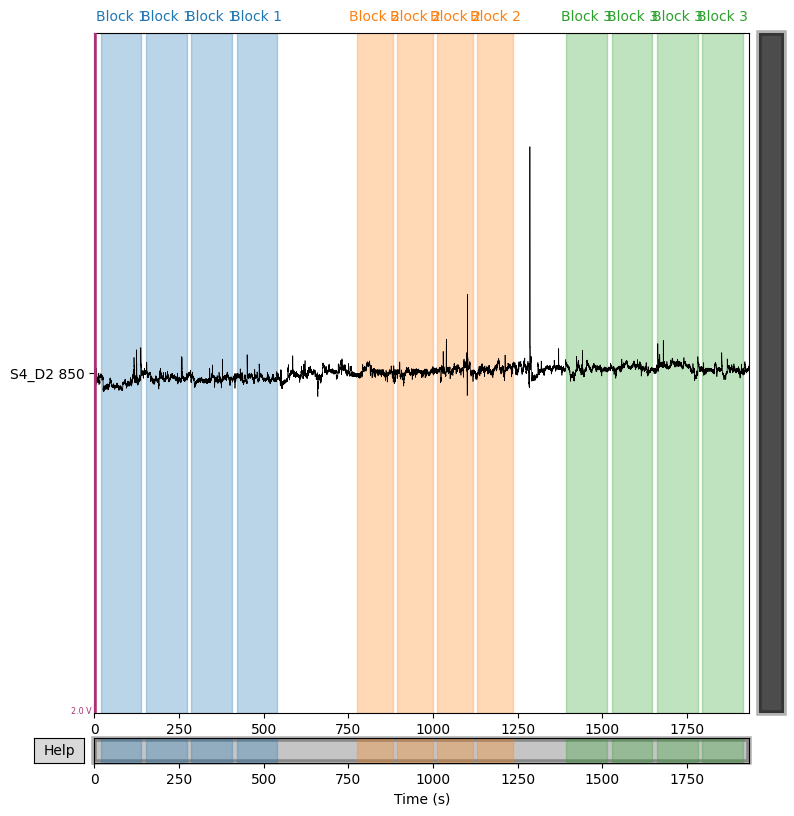

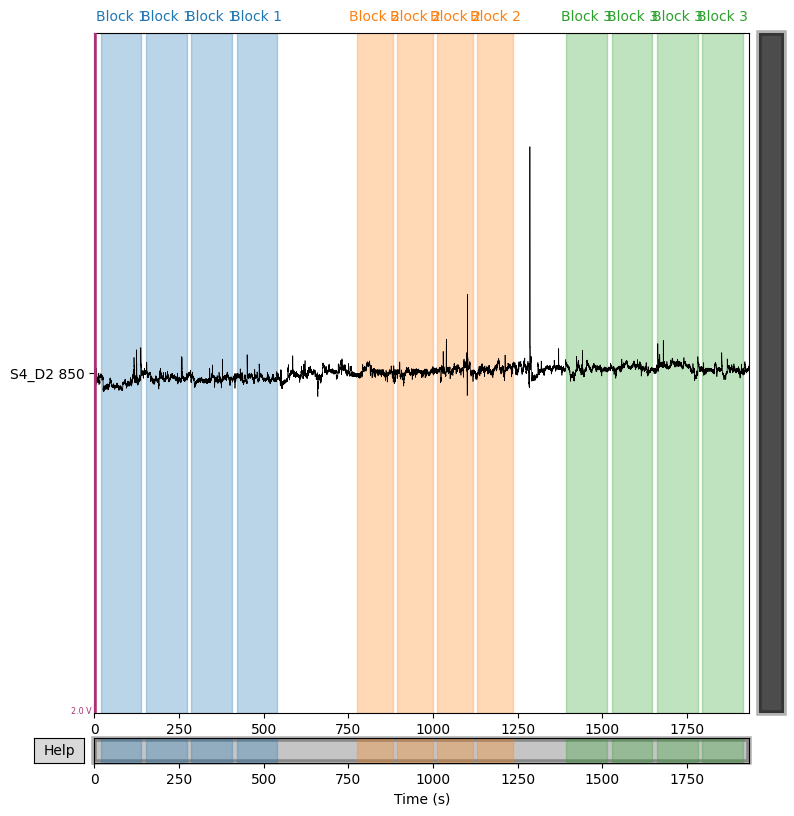

In [515]:
# example Block plot for 3000 seconds
#from this point forward, the first number in brackets following scans denotes subject number (select from 0-115), the 2nd number in brackets denotes whether you want to illustrate child (0) or parent (1) data
scans[20][0].copy().pick(['S4_D2 850']).plot(duration=2000, scalings=1)

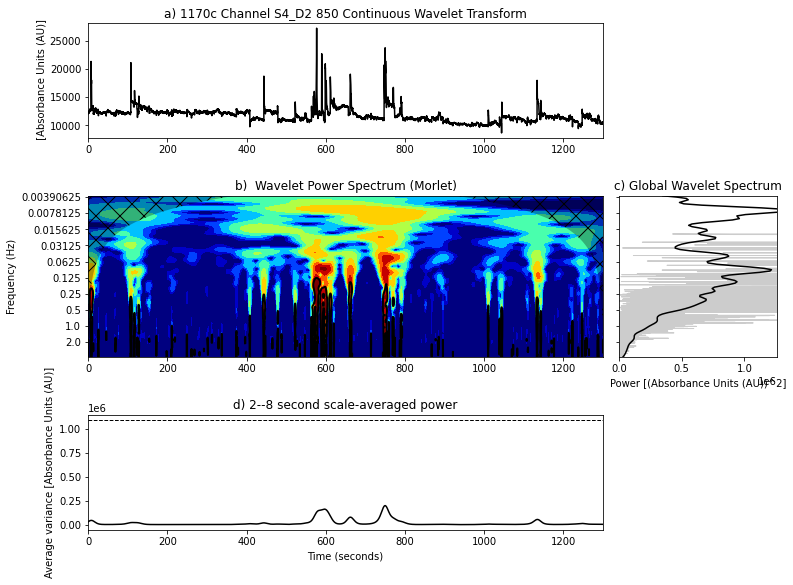

In [516]:
#Concise description of wavelet transform, inputs and outputs that were coded in the function above
wave, scales, freqs, coi, fft, fftfreqs = mne_wavelet_transform(
    #scans is object we built above that contains raw NIRS data from children and parent, to reiterate what was stated above, first index number in brackets
    #is the dyadic pair (can switch to any number of dyadic pairs in data, 2nd index is where you select child (0) or parent (1)
    scans[73][0].copy().crop(tmax=1300),
    #to plot the data, would say False if you want no plot
    plot=True,
    #select the channel(s) you want to visualize data from
    chs=['S4_D2 850'])

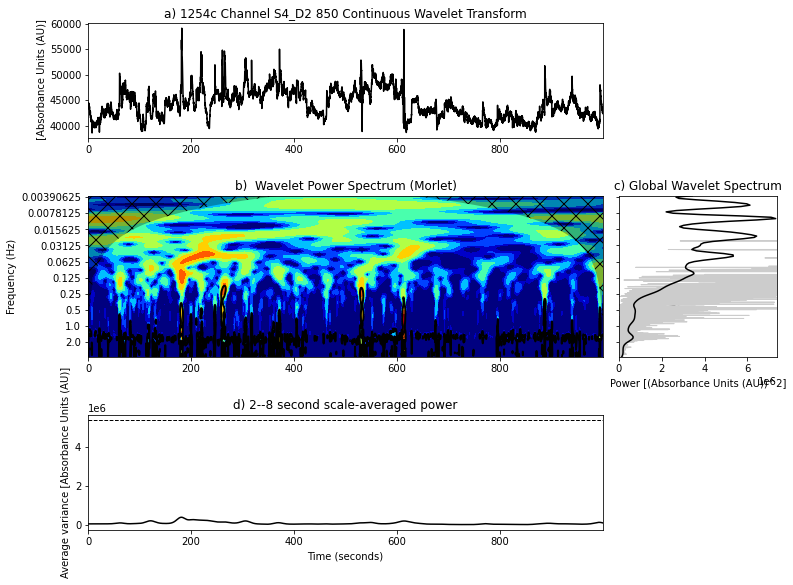

In [517]:
#Concise description of wavelet transform, inputs and outputs that were coded in the function above (clean)
wave, scales, freqs, coi, fft, fftfreqs = mne_wavelet_transform(
    scans[80][0].copy().crop(tmax=1000),
    plot=True,
    chs=['S4_D2 850'])

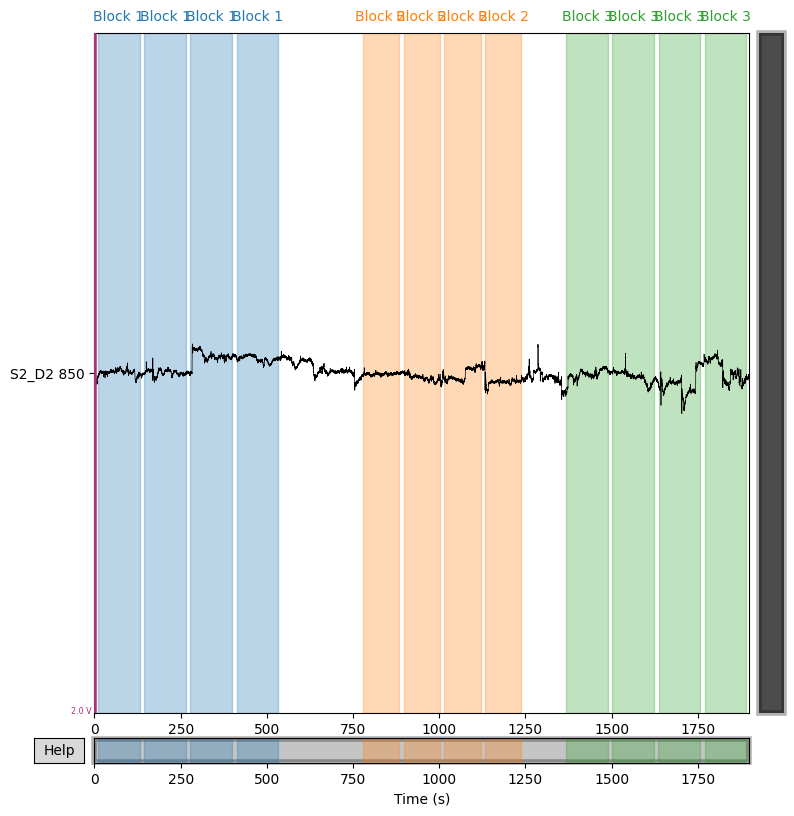

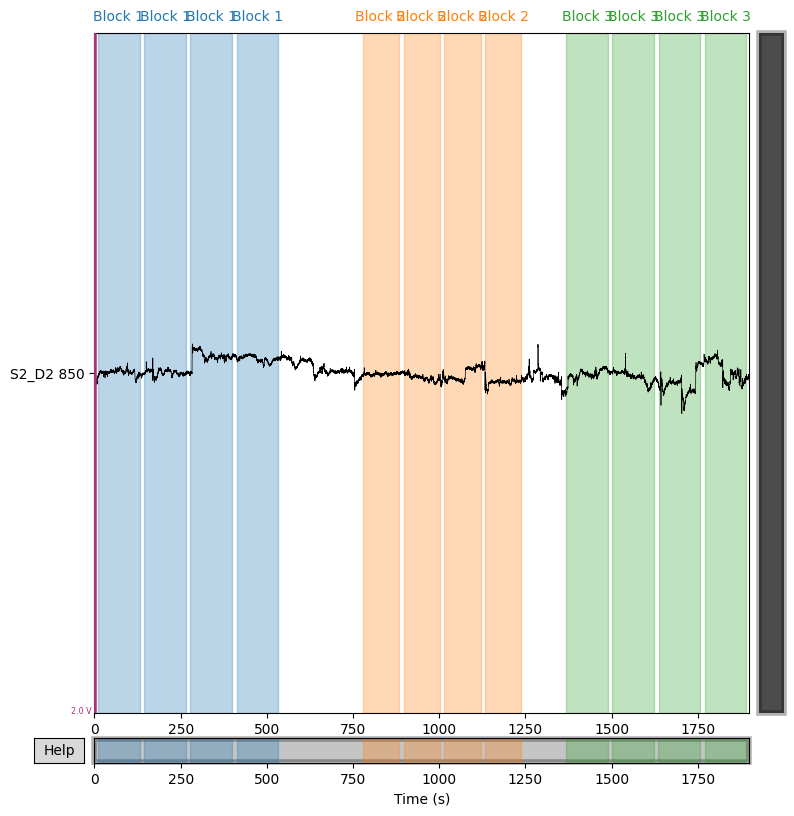

In [518]:
# example plot for 2200 seconds
scans[50][1].copy().pick(['S2_D2 850']).plot(duration=2200, scalings=1)

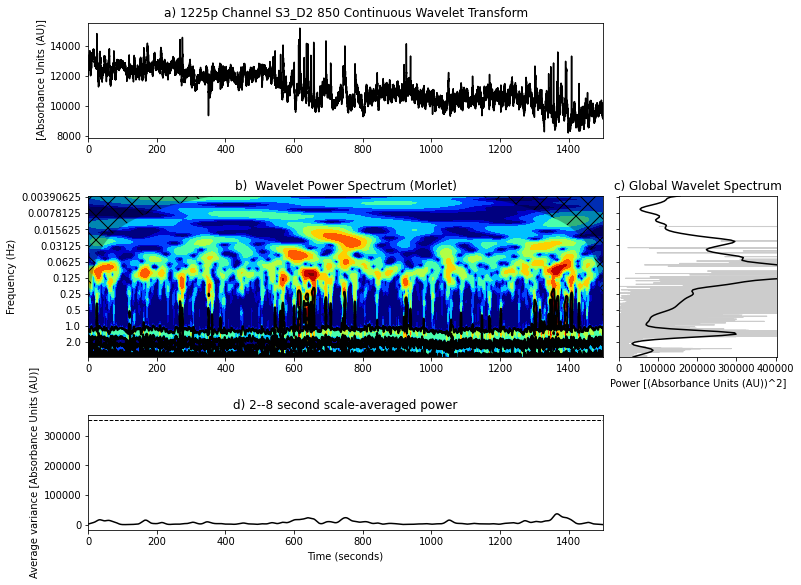

In [519]:
# example wavelet transform for 1800 seconds
wave, scales, freqs, coi, fft, fftfreqs = mne_wavelet_transform(
    scans[3][1].copy().crop(tmax=1500),
    plot=True,
    chs=['S3_D2 850']
)

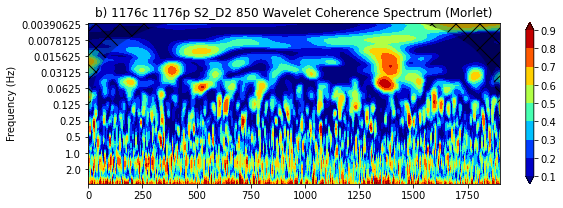

In [520]:
# example coherence transform from a real dyad with 400 seconds (approach 1)
# 0 = child and 1 = parent for the 2nd index point of the scan object
#synchrony value goes from 0 to 1, 1 to max syncrhony
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    scans[30][0].copy().crop(tmax=1900),
    scans[30][1].copy().crop(tmax=1900),
    plot=True,
    chs=['S2_D2 850'])

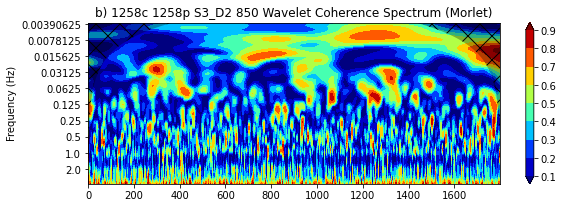

In [521]:
# example coherence transformo from a real dyad with 400 seconds (approach 2)
# 0 = child and 1 = parent for the 2nd index point of the scan object
#synchrony value goes from 0 to 1, 1 to max syncrhony
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    scans[4][0].copy().pick(['S3_D2 850']).crop(tmax=1800),
    scans[4][1].copy().pick(['S3_D2 850']).crop(tmax=1800),
    plot=True)

# Preprocessing Step

Now that data are loaded in and events are correctly distinct, we iterate through each dyad and each individual scan to apply LCBD-standard preprocessing functions. 
- Convert to Optical Density
- Record Scalp-Coupling Index and Mark Channels < 0.5
- Temporal Derivative Distribution Repair (motion correction)
- Beer Lambert Law to Convert to Haemoglobin (c concentration)
- Bandpass Filter 0.01-0.5 Hz

and append those dyads to a list of preprocessed scans. 

In [522]:
#Here the signals collected from the various channels are converted to relaative hemoglobin concentration instead of a frequency waveform,
#which is what we were working with above before preprocessing

# make a list where the preprocessed scans will go
pps = []

# for each dyad scan in scans
for dscan in scans:

    ppdscan = [] # make a list for the preprocessed dyad's scans
    
    # individually preprocess each subject in dyad
    for scan in dscan:
        
        # convert to optical density
        raw_od = mne.preprocessing.nirs.optical_density(scan)

        # scalp coupling index
        sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
        raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))
        
        # linear detrend, par example
#         raw.data[:] = scipy.signal.detrend(raw.get_data(), axis=-1, fit='linear')

        if len(raw_od.info['bads']) > 0:
            print("Bad channels in subject", raw_od.info['subject_info']['his_id'], ":", raw_od.info['bads'])
        
        # temporal derivative distribution repair (motion attempt)
        tddr_od = mne.preprocessing.nirs.tddr(raw_od)
#         print("tddr")
#         tddr_od.plot(
#             n_channels=len(tddr_od.ch_names),
#             scalings=0.1,
#             duration=100,
#             show_scrollbars=False)
        
        # savgol filter (linear polynomial smoothing)
#         sav_od = raw_od.savgol_filter(0.5)
#         print("savgol filtering")
#         sav_od.plot(
#             n_channels=len(sav_od.ch_names),
#             scalings=0.1,
#             duration=100,
#             show_scrollbars=False)

        bp_od = tddr_od.filter(0.01, 0.5)
#         print("bandpass")
#         bp_od.plot(
#             n_channels=len(bp_od.ch_names),
#             duration=100,
#             scalings=0.1,
#             show_scrollbars=False)
    
        # haemoglobin conversion using Beer Lambert Law (this will change channel names from frequency to hemo or deoxy hemo labelling)
        haemo = mne.preprocessing.nirs.beer_lambert_law(bp_od, ppf=0.1)
#         print("haemo")
#         haemo.plot(
#             n_channels=len(haemo.ch_names),
#             duration=100,
#             scalings=0.0001,
#             show_scrollbars=False)

#         print("PSD")
#         haemo_lp.plot_psd(average=True)
        
        ppdscan.append(haemo)
        
    pps.append(ppdscan)

Bad channels in subject 1117c : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 1117p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850']
Bad channels in subject 1144c : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 1160p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850']
Bad channels in subject 1250c : ['S6_D3 760', 'S6_D3 850']
Bad channels in subject 1154c : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 1154p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 1168c : ['S2_D1 760', 'S2_D1 850']
Bad channels in subject 1141p : ['S6_D3 760', 'S6_D3 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 1162c : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 1162p : ['S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 1178p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 1115c : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850',

/tmp/ipykernel_12243/1016720289.py:16: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(scan)


Bad channels in subject 1122c : ['S7_D4 760', 'S7_D4 850']
Bad channels in subject 1189p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 1234p : ['S1_D1 760', 'S1_D1 850', 'S2_D2 760', 'S2_D2 850']
Bad channels in subject 1251p : ['S1_D1 760', 'S1_D1 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 1193c : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 1139c : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850']
Bad channels in subject 1139p : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 1129c : ['S2_D2 760', 'S2_D2 850']
Bad channels in subject 1147p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 1151c : ['S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850']
Bad channels in subject 1149p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 1159p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 1110p : ['S1_D1 760', 'S1_D1 850', 'S3_D2 760', 'S3_D2 850']
Bad channels in subject 1164p : ['S1_D1 760', 'S1_D

In [523]:
#Creating a dictionary variable to store bad channels for later
bad_channels_dict = {}

for dscan in pps:
    
    for scan in dscan:
        
        bads = scan.info['bads']
        bad_channels_dict[scan.info['subject_info']['his_id']] = \
            bads

In [524]:
#Count of number of bad channels to report in any future manuscript (total channels overall is "Number of subjects x 20")
len(bad_channels_dict)

216

In [525]:
bad_channels_dict

{'1267c': [],
 '1267p': [],
 '1177c': [],
 '1177p': [],
 '1117c': ['S1_D1 hbo', 'S1_D1 hbr'],
 '1117p': ['S1_D1 hbo',
  'S1_D1 hbr',
  'S2_D1 hbo',
  'S2_D1 hbr',
  'S2_D2 hbo',
  'S2_D2 hbr',
  'S3_D2 hbo',
  'S3_D2 hbr'],
 '1225c': [],
 '1225p': [],
 '1258c': [],
 '1258p': [],
 '1222c': [],
 '1222p': [],
 '1144c': ['S1_D1 hbo', 'S1_D1 hbr'],
 '1144p': [],
 '1134c': [],
 '1134p': [],
 '1160c': [],
 '1160p': ['S1_D1 hbo',
  'S1_D1 hbr',
  'S2_D1 hbo',
  'S2_D1 hbr',
  'S2_D2 hbo',
  'S2_D2 hbr'],
 '1205c': [],
 '1205p': [],
 '1250c': ['S6_D3 hbo', 'S6_D3 hbr'],
 '1250p': [],
 '1145c': [],
 '1145p': [],
 '1154c': ['S1_D1 hbo', 'S1_D1 hbr'],
 '1154p': ['S1_D1 hbo', 'S1_D1 hbr'],
 '1248c': [],
 '1248p': [],
 '1184c': [],
 '1184p': [],
 '1247c': [],
 '1247p': [],
 '1264c': [],
 '1264p': [],
 '1204c': [],
 '1204p': [],
 '1236c': [],
 '1236p': [],
 '1168c': ['S2_D1 hbo', 'S2_D1 hbr'],
 '1168p': [],
 '1141c': [],
 '1141p': ['S6_D3 hbo', 'S6_D3 hbr', 'S8_D4 hbo', 'S8_D4 hbr'],
 '1138c': [],
 '

In [526]:
bad_channels_dict['1148p']

['S1_D1 hbo', 'S1_D1 hbr']

In [527]:
pps[7][0].info['subject_info']

{'his_id': '1134c',
 'first_name': '1134-Child',
 'sex': 0 (FIFFV_SUBJ_SEX_UNKNOWN),
 'birthday': (2022, 3, 25)}

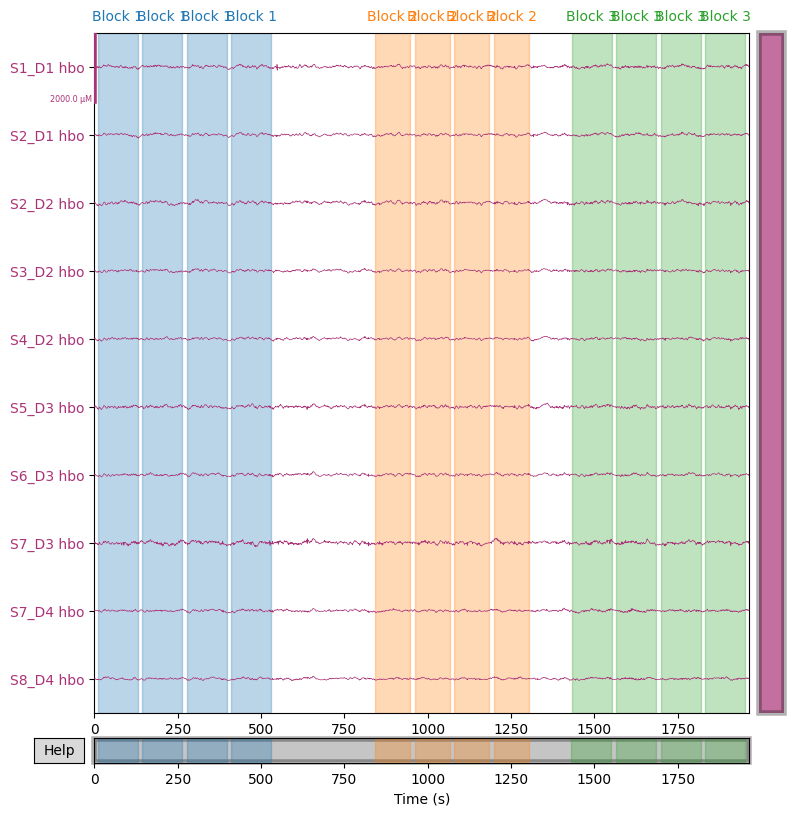

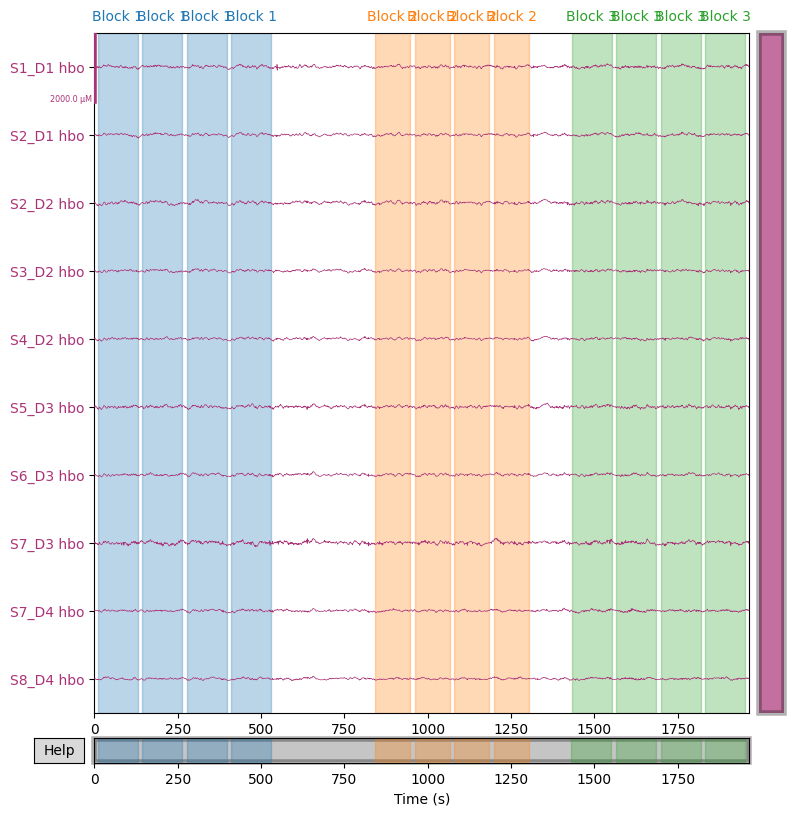

In [528]:
# example plot for 2200 seconds
#can either plot all hbo channels or a single channel for a subject
pps[51][0].copy().pick(['hbo']).plot(duration=2000, scalings=0.001)

In [529]:
sampling_rate = pps[0][0].info['sfreq']
print(sampling_rate)

7.8125


In [530]:
pps[10][0]

<RawNIRX | 1250-C_fNIRS_DB-DOS, 20 x 15448 (1977.2 s), ~2.4 MB, data loaded>

In [531]:
# make a dictionary where all of the epoch'd data will go
epoch_df = {}

# loop over the dyads in the preprocessed list
for dscan in pps:
    
    # February 9th 2023
    # Clayton update to prune subjects who have
    # >= 10 channels dropped from the SCI function during preprocessing
    max_bad = max([len(scan.info['bads']) for scan in dscan])
    # whichever number is higher ^, num. of channels dropped in
    # either parent or child
    
    if max_bad >= 10:
        for scan in dscan:
            sub_num = scan.info['subject_info']['his_id']
            print("Subject {} was dropped from further analysis.".format(sub_num))
        
        continue # skip this dyad
        # if max_bad is greater than or equal to 10
    
    # for each scan in the dyad
    for scan in dscan:
    
        # set their location in the epoch df to a dictionary
        epoch_df[scan.info['subject_info']['his_id']] = {}
    
#        for i, ROI in enumerate(ROIs.keys()):

        # loop over ROIs (channels here)
        for i, ROI in enumerate([ch for ch in scan.info['ch_names'] if "hbo" in ch]):
            
            epoch_df[scan.info['subject_info']['his_id']][ROI] = []
        
            # get their events and set block durations
            events, event_dict = mne.events_from_annotations(dscan[0], verbose=False)
            reject_criteria = dict(hbo=200e-6)
            tmin, puzzletmax, playtmax = -5, 105, 120
            
            # use the mne.Epochs function / object to generate epochs
            preplay_epochs = mne.Epochs(
                scan, # the scan object
                events, # its events
#                 picks=ROIs[ROI],
                picks=[ROI], # the channels
                event_id={list(event_dict.keys())[0]: list(event_dict.values())[0]}, # the first event key
                tmin=tmin, # epoch relative start time
                tmax=playtmax, # epoch relative end time
                baseline= (None, 0), # baseline window to subtract
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1, # linear detrend
                verbose=False, 
                preload=False, # don't actually load it yet (saves memory)
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(preplay_epochs)
            
            puzzle_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[1]: list(event_dict.values())[1]},
                tmin=tmin,
                tmax=puzzletmax,
                baseline= (None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(puzzle_epochs)
            
            postplay_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[2]: list(event_dict.values())[2]},
                tmin=tmin,
                tmax=playtmax,
                baseline=(None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(postplay_epochs)

Subject 1115c was dropped from further analysis.
Subject 1115p was dropped from further analysis.
Subject 1176c was dropped from further analysis.
Subject 1176p was dropped from further analysis.
Subject 1130c was dropped from further analysis.
Subject 1130p was dropped from further analysis.


In [532]:
# here is the way to access information in the epoch dictionary

In [533]:
#Will tell you how many dyads are retaining for final analyses 
len([sub for sub in epoch_df.keys() if "c" in sub])

105

In [534]:
# a single subject 
epoch_df['1250c']

{'S1_D1 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 3': 4>],
 'S2_D1 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 3': 4>],
 'S2_D2 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 se

In [535]:
# a specific channel from the subject
epoch_df['1250c']['S1_D1 hbo']

[<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 1': 4>,
 <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 2': 4>,
 <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 3': 4>]

In [536]:
# a specific block at that subject / channel, in this case the first (0) is pre-play, second (1) is puzzle, and second (2) is post-play
#ask Susan about baseline 
epoch_df['1250c']['S1_D1 hbo'][2]

Number of events,4
Events,Block 3: 4
Time range,-4.992 – 120.064 sec
Baseline,-4.992 – 0.000 sec


In [537]:
# a specific iteration (trial) of that block at that subject / channel, in this case the first (0) is pre-play, we look at the 4th (3) iteration of the block
#120 sec duration of individual trial/iteration
epoch_df['1250c']['S1_D1 hbo'][0][3]

Number of events,1
Events,Block 1: 1
Time range,-4.992 – 120.064 sec
Baseline,-4.992 – 0.000 sec


In [538]:
event_dict

{'Block 1': 1, 'Block 2': 2, 'Block 3': 3}

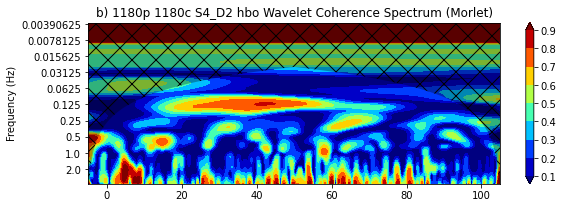

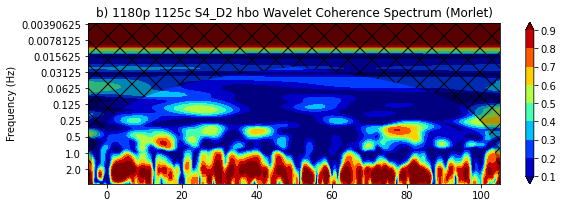

In [540]:
# example WCT between a real dyad, puzzle block (1), iteration 0 (0)
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['1180p']['S4_D2 hbo'][1][0].copy(),
    epoch_df['1180c']['S4_D2 hbo'][1][0].copy(),
    plot=True)

# same WCT but a random false dyad
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['1180p']['S4_D2 hbo'][1][0].copy(),
    epoch_df['1125c']['S4_D2 hbo'][1][0].copy(),
    plot=True)

In [541]:
# list out all the subjects in the epoch df
epoch_df.keys()

dict_keys(['1267c', '1267p', '1177c', '1177p', '1117c', '1117p', '1225c', '1225p', '1258c', '1258p', '1222c', '1222p', '1144c', '1144p', '1134c', '1134p', '1160c', '1160p', '1205c', '1205p', '1250c', '1250p', '1145c', '1145p', '1154c', '1154p', '1248c', '1248p', '1184c', '1184p', '1247c', '1247p', '1264c', '1264p', '1204c', '1204p', '1236c', '1236p', '1168c', '1168p', '1141c', '1141p', '1138c', '1138p', '1162c', '1162p', '1178c', '1178p', '1223c', '1223p', '1126c', '1126p', '1231c', '1231p', '1188c', '1188p', '1213c', '1213p', '1186c', '1186p', '1202c', '1202p', '1131c', '1131p', '1266c', '1266p', '1268c', '1268p', '1125c', '1125p', '1220c', '1220p', '1148c', '1148p', '1253c', '1253p', '1127c', '1127p', '1200c', '1200p', '1179c', '1179p', '1116c', '1116p', '1122c', '1122p', '1244c', '1244p', '1189c', '1189p', '1246c', '1246p', '1214c', '1214p', '1143c', '1143p', '1219c', '1219p', '1234c', '1234p', '1251c', '1251p', '1193c', '1193p', '1139c', '1139p', '1242c', '1242p', '1129c', '1129p',

In [310]:
# delete things we don't need anymore to save memory
del scans
del pps

In [311]:
import random

In [ ]:
# make a new dictionary where the synchrony values will be stored
sync_df = {}
block_types = ['Block 1', 'Block 2', 'Block 3']
perm_df = {}

# THIS TAKES A REALLY LONG TIME TO COMPUTE. AROUND 48 HOURS ON A DECENT NETWORK
# SKIP DOWN TO USE THE SAVED VERSIONS!

#real vs single false dyad test of a myriad of real and fake dyad pairs

# for every parent subject
for parent in tqdm([sub for sub in sorted(epoch_df.keys()) if "p" in sub]):
    sync_df[parent] = {}
    perm_df[parent] = []
    
    # pick two children, one real and one random
    children = []
    
#     children.append(parent.replace("p", "c")) # real child
    
    # random sample of N children
    # could be repeated, could be the real dyad 
    randoms = random.choices(
        [sub for sub in epoch_df.keys() if "c" in sub],
        k=999) # N of random 
    # randoms = list(randoms).insert(0, parent.replace("p", "c"))
    perm_df[parent] = list(randoms)
    
    # only going to do synchrony once per kid
    # we can count # of repeats from perm_df[parent]
    for child in list(set(randoms)):
        children.append(child)
    
    # old version that just does 1 random non-real child per parent
#     children.append(
#         random.choice([sub for sub in epoch_df.keys() if "c" in sub \
#             and parent.replace("p", "") not in sub])) # random pick
    
    # loop over these 2 selected children (1 real, N random)
    for child in children:
        
        # and make them a location in the sync dictionary under this parent
        sync_df[parent][child] = {}
        
        # for every block type (pre-play, puzzle, post-play)
        for block_num, block in enumerate(block_types):
            
            # make this parent/child combo a location for this block type, also a dictionary
            sync_df[parent][child][block] = {}
                
            # for each channel available with this subject (not dropped)
            for ch in epoch_df[parent].keys():
                
                # our sync value is going to go here
                # sync_df[parent][child][block][ch]
                # i.e. averaging over the 4 block iterations
                
                # so start keeping track of values to average now
                pc_wcts = []
                
                # load in their epoched data for this subject / channel / block
                p_epoch = epoch_df[parent][ch][block_num].load_data()
                c_epoch = epoch_df[child][ch][block_num].load_data()
                
                # for each iteration of this block (max 4)
                for block_it in np.arange(0, np.min([
                    len(p_epoch),
                    len(c_epoch)])):
                    
                    # try to do the WCT with these epochs
                    try:
                        WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
                            p_epoch[block_it],
                            c_epoch[block_it],
                            plot=True if "S5_D3" in ch else False, # save plots but only for some random channel because otherwise it's an insane amount
                            fig_fname=f"/data/perlman/moochie/analysis/eDOC_NARSAD/sync_figs/{parent}_{child}_{ch.replace(' ', '_')}_{block_num}_{block_it}.png")

                        # make values outside COI = np.nan
                        nanWCT = WCT
                        for t in range(nanWCT.shape[1]):
                            nanWCT[np.where(freqs>coi[t]), t] = np.nan
                        # also set to nan outside frequencies of interest
                        
                        # TASK RELATED FREQUENCIES ARE ARBITRARILY DETERMINED here
                        WCT[(5>(1/freqs))|((1/freqs)>105), :] = np.nan
                        
                        # between periods of 5s and 105s (.0095 -.2 Hz; flip for sec) which is based on Nguyen et al 2021 paper
                       

                        # average inside cone of influence
                        # and within values from freq range determined above
                        pc_wcts.append(np.nanmean(nanWCT))
    #                     print(np.nanmean(nanWCT))
    
                    # if anything with the WCT fails, say so
                    except:
                        print(f"Fail @ parent {parent}, child {child}, block {block}, channel {ch}, block it {block_it}")
#                 print(np.average(pc_wcts))  
                sync_df[parent][child][block][ch] = np.average(pc_wcts)

 78%|████████████████████████████        | 82/105 [21:22:24<5:56:27, 929.90s/it]

In [ ]:
sync_df

In [543]:
list(sync_df['1194p']['1194c']['Block 2'].values())

[0.3033389131312753,
 nan,
 0.29279359861364795,
 0.2984791755332375,
 0.3208923653937908,
 0.2914945991741763,
 0.33218813632384603,
 0.32348987043693167,
 0.3579758266320137,
 0.26713600575066576]

In [544]:
#important to set channels here
channels = epoch_df[parent].keys()

In [545]:
channels

dict_keys(['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo', 'S3_D2 hbo', 'S4_D2 hbo', 'S5_D3 hbo', 'S6_D3 hbo', 'S7_D3 hbo', 'S7_D4 hbo', 'S8_D4 hbo'])

In [546]:
epoch_df['1176p']

KeyError: '1176p'

In [193]:
# ATTENTION READ THE FOLLOWING COMMENT CAREFULLY BEFORE PROCEEDING (Stats test are being ran concerning study hypotheses, use a different notebook)

In [197]:
# skip if you're going to load the already-saved ones. for real. don't overwrite this with an empty data file. 
# SAVE SYNCHRONY VALUES

import json
json_object = json.dumps(sync_df, indent=4)

with open("/data/perlman/moochie/analysis/P-CAT/Test_Analysis/wct_full_permuted_values_new_1.json", 'w') as outfile:
    json.dump(sync_df, outfile)
    
    
# also save as CSV
import pandas as pd

cols = ["Parent", "Child", "Block"]
for ch in channels:
    cols.append(ch)
    
df = pd.DataFrame(columns=cols)    

for parent in sync_df.keys():
    
    for child in sync_df[parent].keys():
        
        for block in sync_df[parent][child].keys():
            
            dic = {
                'Parent': parent,
                'Child': child,
                'Block': block}
            
            for key, val in sync_df[parent][child][block].items():
                dic[key] = val
            
#             print(dic)
            df = df.append(dic, ignore_index=True)
        
print(df)
df.to_csv("/data/perlman/moochie/analysis/P-CAT/Test_Analysis/wct_full_permuted_values_new_1.csv")

      Parent  Child    Block  S1_D1 hbo  S2_D1 hbo  S2_D2 hbo  S3_D2 hbo  \
0      1110p  1127c  Block 1   0.332259   0.234967   0.220130   0.306761   
1      1110p  1127c  Block 2   0.337315   0.329162   0.288846   0.271882   
2      1110p  1127c  Block 3   0.254967   0.271699   0.253931   0.210328   
3      1110p  1195c  Block 1   0.233899   0.237311   0.262895   0.253767   
4      1110p  1195c  Block 2   0.310799   0.231103   0.269739   0.276811   
...      ...    ...      ...        ...        ...        ...        ...   
33067  1270p  1133c  Block 2   0.253837   0.286233   0.281507   0.290637   
33068  1270p  1133c  Block 3   0.244682   0.297320   0.300591   0.268739   
33069  1270p  1258c  Block 1   0.240454   0.373713   0.306436   0.246087   
33070  1270p  1258c  Block 2   0.281526   0.268689   0.298391   0.344648   
33071  1270p  1258c  Block 3   0.270135   0.305270   0.279166   0.233098   

       S4_D2 hbo  S5_D3 hbo  S6_D3 hbo  S7_D3 hbo  S7_D4 hbo  S8_D4 hbo  
0       0.221

In [547]:
# Save permuted values

json_object = json.dumps(perm_df, indent=4)
with open("/data/perlman/moochie/analysis/P-CAT/Test_Analysis/permuted_subjects_(5-105).json", 'w') as outfile:
    json.dump(perm_df, outfile)

In [548]:
# LOAD PERMUTED SYNCHRONY VALUES from the saved file, saving time and precious CPU-hours

import json
with open("/data/perlman/moochie/analysis/P-CAT/Test_Analysis/permuted_subjects_(5-105).json", 'r') as infile:
    perm_df = json.load(infile)

In [549]:
# LOAD REAL SYNCHRONY VALUES from the saved file, saving time and precious CPU-hours

import json
with open("/data/perlman/moochie/analysis/P-CAT/Test_Analysis/wct_full_permuted_values_(5-105).json", 'r') as infile:
    sync_df = json.load(infile)

In [550]:
# how many parents are in there (some may be repeated because they have multiple children in the study)
len(sync_df.keys())

105

In [551]:
sync_df.keys()

dict_keys(['1110p', '1113p', '1114p', '1116p', '1117p', '1121p', '1122p', '1124p', '1125p', '1126p', '1127p', '1129p', '1131p', '1133p', '1134p', '1137p', '1138p', '1139p', '1141p', '1143p', '1144p', '1145p', '1146p', '1147p', '1148p', '1149p', '1151p', '1154p', '1155p', '1156p', '1159p', '1160p', '1162p', '1164p', '1165p', '1167p', '1168p', '1170p', '1172p', '1173p', '1174p', '1175p', '1177p', '1178p', '1179p', '1180p', '1182p', '1184p', '1185p', '1186p', '1187p', '1188p', '1189p', '1190p', '1193p', '1194p', '1195p', '1200p', '1202p', '1203p', '1204p', '1205p', '1207p', '1209p', '1211p', '1213p', '1214p', '1216p', '1219p', '1220p', '1222p', '1223p', '1225p', '1226p', '1227p', '1228p', '1229p', '1231p', '1232p', '1234p', '1235p', '1236p', '1240p', '1242p', '1244p', '1245p', '1246p', '1247p', '1248p', '1250p', '1251p', '1252p', '1253p', '1254p', '1255p', '1256p', '1258p', '1263p', '1264p', '1265p', '1266p', '1267p', '1268p', '1269p', '1270p'])

In [552]:
# how many parents are in there, without repeats
len(set([sub[:-2] for sub in list(sync_df.keys())]))

17

In [553]:
#THE BEGINNING OF REAL VS FALSE DYADS STATS

In [554]:
pruned_sync_df = copy(sync_df)

In [555]:
#BAD CHANNEL PRUNING
for parent in pruned_sync_df.keys():
    
    for child in pruned_sync_df[parent].keys():
        
        for block in pruned_sync_df[parent][child].keys():
            
            for channel in pruned_sync_df[parent][child][block].keys():
                
                
                if (parent in bad_channels_dict.keys() and channel in bad_channels_dict[parent]):
                    pruned_sync_df[parent][child][block][channel] = np.nan
                    
                if (child in bad_channels_dict.keys() and channel in bad_channels_dict[child]):
                    pruned_sync_df[parent][child][block][channel] = np.nan

In [556]:
np.isnan(pruned_sync_df['1250p']['1250c']['Block 1']['S1_D1 hbo'])

False

In [557]:
#1) AVERAGE ACROSS All ROIs

In [558]:
#to check whether all real dyads are included in the permuted excel file
for parent in sync_df.keys(): 
    if not (parent.replace("p", "c") in sync_df[parent].keys()):
        print(parent)

In [559]:
dyad_b1 = [] # make a base list for real dyads
nyad_b1 = [] # make a base list for false dyads

# this is just using Block 1 = Pre-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in list(sync_df[parent][real_child]['Block 1'].keys()):
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_b1.append(
                sync_df[parent][real_child]['Block 1'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in list(sync_df[parent][false_child]['Block 1'].keys()):
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_b1.append(
                    sync_df[parent][false_child]['Block 1'][ch])
                
    #REMOVE NaN values from REAL dyad list
    dyad_list1 = []
    dyad_list2 = []
    dyad_b1_new = [] #this will be new real dyad variable 

    for x in dyad_b1:
        x = str(x)
        dyad_list1 += [x]

    for x in dyad_list1:
        if x == 'nan':
            del x
        else:
            dyad_list2 += [x]

    for x in dyad_list2:
        x = float(x)
        dyad_b1_new += [x]
        
    #REMOVE NaN values from FALSE dyad list
    nyad_list1 = []
    nyad_list2 = []
    nyad_b1_new = [] #this will be the new false dyad variable

    for x in nyad_b1:
        x = str(x)
        nyad_list1 += [x]

    for x in nyad_list1:
        if x == 'nan':
            del x
        else:
            nyad_list2 += [x]

    for x in nyad_list2:
        x = float(x)
        nyad_b1_new += [x]

In [560]:
dyad_b2 = [] # make a list for real dyads
nyad_b2 = [] # make a list for not-real dyads

# this is just using Block 2 = Puzzle

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in list(sync_df[parent][real_child]['Block 2'].keys()):
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_b2.append(
                sync_df[parent][real_child]['Block 2'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in list(sync_df[parent][false_child]['Block 2'].keys()):
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_b2.append(
                    sync_df[parent][false_child]['Block 2'][ch])
                
    #REMOVE NaN values from REAL dyad list
    dyad_list1 = []
    dyad_list2 = []
    dyad_b2_new = [] #this will be new real dyad variable 

    for x in dyad_b2:
        x = str(x)
        dyad_list1 += [x]

    for x in dyad_list1:
        if x == 'nan':
            del x
        else:
            dyad_list2 += [x]

    for x in dyad_list2:
        x = float(x)
        dyad_b2_new += [x]
        
    #REMOVE NaN values from FALSE dyad list
    nyad_list1 = []
    nyad_list2 = []
    nyad_b2_new = [] #this will be the new false dyad variable

    for x in nyad_b2:
        x = str(x)
        nyad_list1 += [x]

    for x in nyad_list1:
        if x == 'nan':
            del x
        else:
            nyad_list2 += [x]

    for x in nyad_list2:
        x = float(x)
        nyad_b2_new += [x]

In [561]:
dyad_b3 = [] # make a list for real dyads
nyad_b3 = [] # make a list for not-real dyads

# this is just using Block 3 = Post-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in list(sync_df[parent][real_child]['Block 3'].keys()):
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_b3.append(
                sync_df[parent][real_child]['Block 3'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in list(sync_df[parent][false_child]['Block 3'].keys()):
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_b3.append(
                    sync_df[parent][false_child]['Block 3'][ch])
                
    #REMOVE NaN values from REAL dyad list
    dyad_list1 = []
    dyad_list2 = []
    dyad_b3_new = [] #this will be new real dyad variable 

    for x in dyad_b3:
        x = str(x)
        dyad_list1 += [x]

    for x in dyad_list1:
        if x == 'nan':
            del x
        else:
            dyad_list2 += [x]

    for x in dyad_list2:
        x = float(x)
        dyad_b3_new += [x]
        
    #REMOVE NaN values from FALSE dyad list
    nyad_list1 = []
    nyad_list2 = []
    nyad_b3_new = [] #this will be the new false dyad variable

    for x in nyad_b3:
        x = str(x)
        nyad_list1 += [x]

    for x in nyad_list1:
        if x == 'nan':
            del x
        else:
            nyad_list2 += [x]

    for x in nyad_list2:
        x = float(x)
        nyad_b3_new += [x]

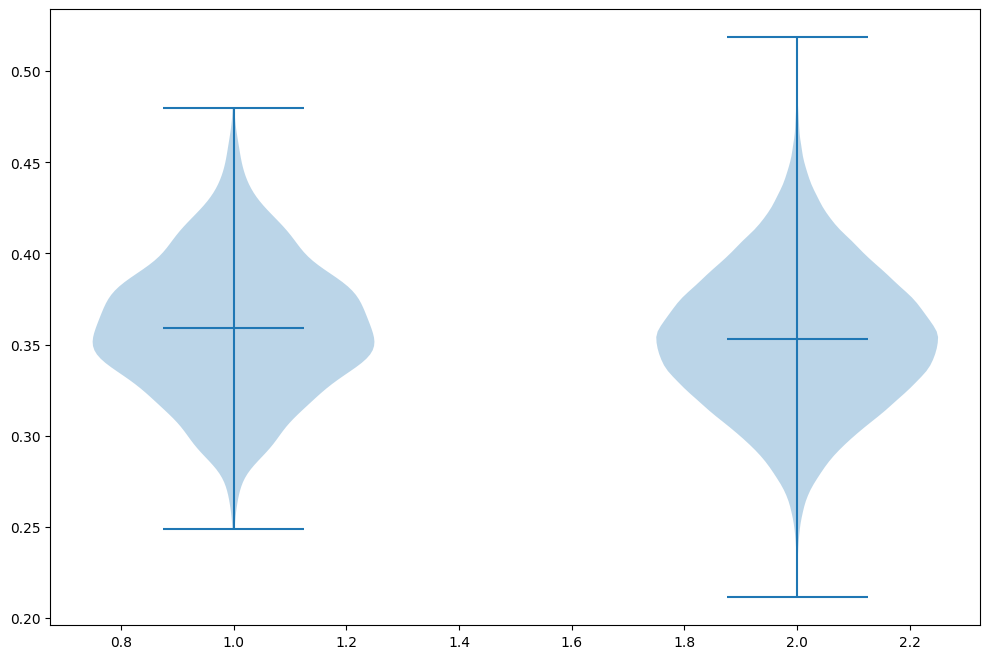

In [322]:
plt.clf()
plt.violinplot(
    [dyad_b1_new, nyad_b1_new],
    showmeans=True,
#     showmedians=True,
)
plt.show()

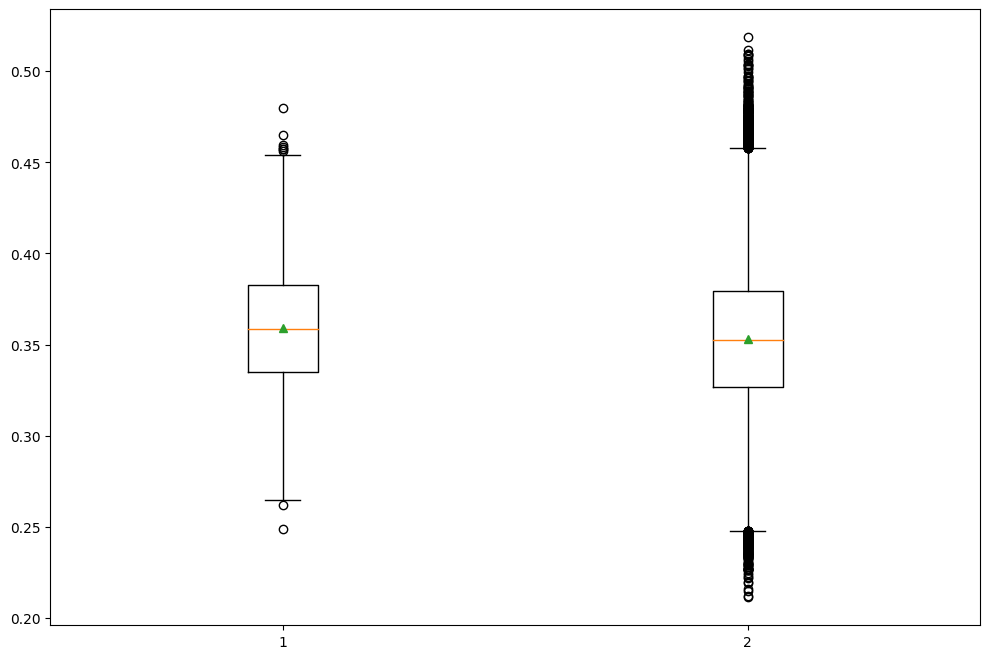

In [323]:
#synchrony values of real and non-real dyads plotted
plt.boxplot(
    [dyad_b1_new, nyad_b1_new],
    showmeans=True,
#     showmedians=True,
)
plt.show()

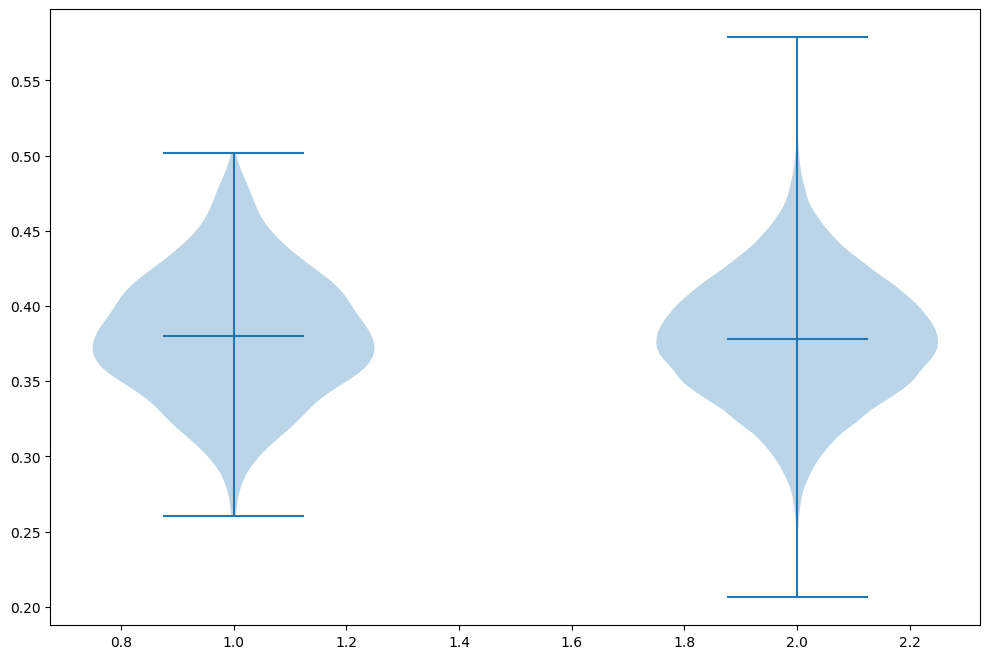

In [324]:
plt.clf()
plt.violinplot(
    [dyad_b2_new, nyad_b2_new],
    showmeans=True,
#     showmedians=True,
)
plt.show()

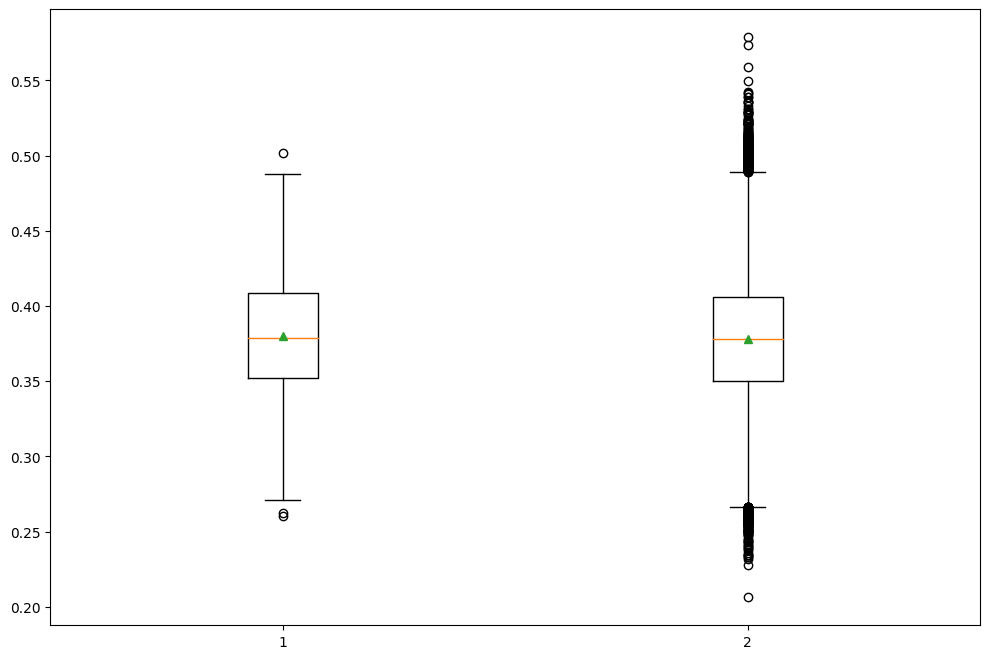

In [325]:
#synchrony values of real and non-real dyads plotted
plt.boxplot(
    [dyad_b2_new, nyad_b2_new],
    showmeans=True,
#     showmedians=True,
)
plt.show()

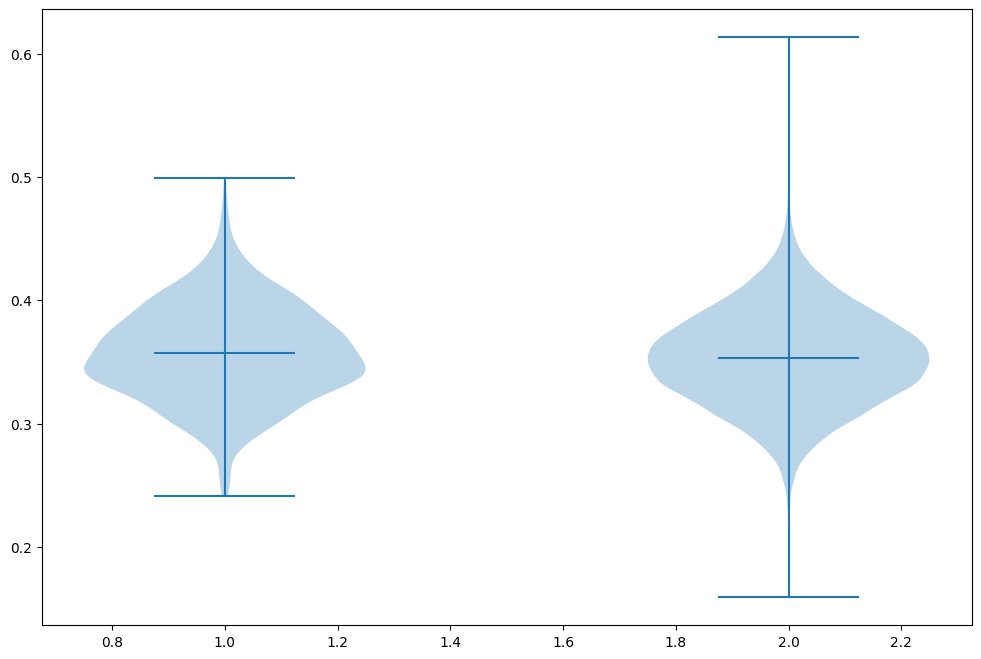

In [326]:
plt.clf()
plt.violinplot(
    [dyad_b3_new, nyad_b3_new],
    showmeans=True,
#     showmedians=True,
)
plt.show()

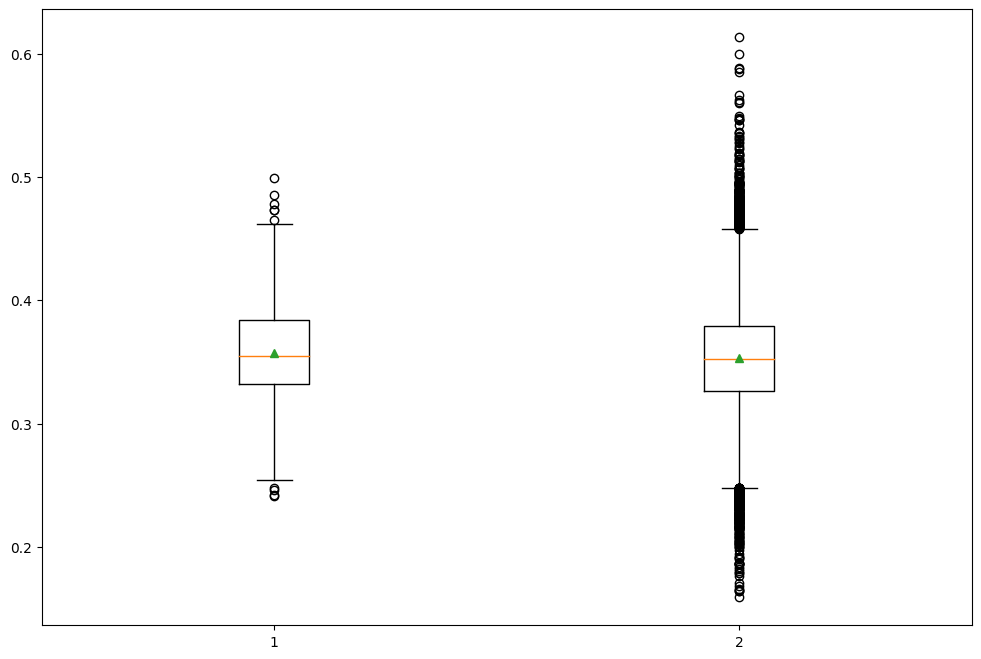

In [327]:
#synchrony values of real and non-real dyads plotted
plt.boxplot(
    [dyad_b3_new, nyad_b3_new],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [562]:
#TWO SAMPLE T-TESTS ARE RAN HERE

In [563]:
from scipy.stats import ttest_ind

In [564]:
#Pre-Play
statistic, pvalue = ttest_ind(
    dyad_b1_new,
    nyad_b1_new)

In [565]:
statistic

4.625888480596827

In [566]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 3.734476403602435e-06


In [567]:
#Puzzle
statistic, pvalue = ttest_ind(
    dyad_b2_new,
    nyad_b2_new)

In [568]:
statistic

1.7082447679310844

In [569]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 0.08759394011247153


In [570]:
#Post-Play
statistic, pvalue = ttest_ind(
    dyad_b3_new,
    nyad_b3_new)

In [571]:
statistic

3.213765309998888

In [572]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 0.0013104691720445647


In [342]:
#REAL vs BASELINE (zeroes)/One-Sample T-Tests 

In [343]:
#find length of block variable first for each real or false synchrony scores
len(dyad_b1_new)

974

In [237]:
#Set a list of zeroes for one-sample t-test comparisons
zyad_z1 = []

for num in range(974):
    zyad_z1.append(0)

In [238]:
#One-Sample T-tests 
statistic, pvalue = ttest_ind(
    dyad_b1_new,
    zyad_z1)

In [239]:
statistic

252.05466994776467

In [240]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 0.0


In [203]:
#TESTING BETWEEN BLOCK DIFFERECNES BETWEEN REAL DYADS (AVERAGE ACROSS ALL BLOCKS) THERE SHOULD BE 3 COMBINATIONS TOTAL

In [350]:
#Block by Block Conparisons, Real Dyads ONLY!
statistic, pvalue = ttest_ind(
    dyad_b1_new,
    dyad_b3_new)

In [351]:
statistic

2.0151240430740174

In [352]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 0.044028928318057915


In [208]:
#2) HERE CAN TEST SPECIFIC ROIs (CHANNELS) BETWEEN REAL vs FALSE DYADS

In [600]:
#Use these cells below to test specific channels

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
  'S3_D2 hbo', # left frontal
  'S4_D2 hbo',
  'S5_D3 hbo', # right frontal
  'S6_D3 hbo',
#    'S1_D1 hbo', # left temporal
#    'S2_D1 hbo',
#    'S2_D2 hbo',
#    'S7_D3 hbo', #right temporal
#    'S7_D4 hbo',
#    'S8_D4 hbo'
]

dyad_c1 = [] # make a list for real dyads
nyad_c1 = [] # make a list for not-real dyads

# this is just using Block 1 = Pre-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in channels:
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_c1.append(
                sync_df[parent][real_child]['Block 1'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in channels:
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_c1.append(
                    sync_df[parent][false_child]['Block 1'][ch])

In [601]:
#Pre-Play T-test (Real vs False Dyads) - Specific Channels
statistic, pvalue = ttest_ind(
    dyad_c1,
    nyad_c1)

In [602]:
statistic

nan

In [603]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: nan


In [604]:
#Use these cells below to test specific channels

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
    'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
#      'S5_D3 hbo', # right frontal
#      'S6_D3 hbo',
     'S1_D1 hbo', # left temporal
     'S2_D1 hbo',
     'S2_D2 hbo',
#      'S7_D3 hbo', #right temporal
#      'S7_D4 hbo',
#      'S8_D4 hbo'
]

dyad_c2 = [] # make a list for real dyads
nyad_c2 = [] # make a list for not-real dyads

# this is just using Block 2 = Puzzle

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in channels:
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_c2.append(
                sync_df[parent][real_child]['Block 2'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in channels:
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_c2.append(
                    sync_df[parent][false_child]['Block 2'][ch])

In [605]:
#Puzzle T-test (Real vs False Dyads) - Specific Channels
statistic, pvalue = ttest_ind(
    dyad_b2,
    nyad_c2)

In [606]:
statistic

nan

In [607]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: nan


In [677]:
#Use these cells below to test specific channels

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
      'S3_D2 hbo', # left frontal
      'S4_D2 hbo',
#       'S5_D3 hbo', # right frontal
#       'S6_D3 hbo',
      'S1_D1 hbo', # left temporal
      'S2_D1 hbo',
      'S2_D2 hbo',
#       'S7_D3 hbo', #right temporal
#       'S7_D4 hbo',
#       'S8_D4 hbo'
]

dyad_c3 = [] # make a list for real dyads
nyad_c3 = [] # make a list for not-real dyads

# this is just using Block 3 = Post-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in channels:
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_c3.append(
                sync_df[parent][real_child]['Block 3'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in channels:
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_c3.append(
                    sync_df[parent][false_child]['Block 3'][ch])

In [678]:
#Post-Play T-test (Real vs False Dyads) - Specific Channels
statistic, pvalue = ttest_ind(
    dyad_c3,
    nyad_c3)

In [679]:
statistic

nan

In [680]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: nan


In [ ]:
#INCORPORATION of FACES QUESTIONNAIRE SCORES BEGINS HERE (other PCAT Measures will be included here)

In [ ]:
#The code and CSV for the OLD RDAS files for reference (DON'T RUN THIS SECTION)

In [ ]:
# load CSV from emily Hone groups
# groups = pd.read_csv("/data/perlman/moochie/analysis/CARE/forperlman_rdaslist_20221101.csv")
# groups['subject'] = [id.replace('-', '') for id in groups['record_id']]
# groups.set_index('subject', inplace=True)

In [612]:
#groups

NameError: name 'groups' is not defined

In [ ]:
# load CSV from emily Hone's RDAS scores
# scores = pd.read_csv("/data/perlman/moochie/analysis/CARE/forkhalil_fullscored.csv")
# scores['subject'] = [id.replace('-', '') for id in scores['record_id']]
# scores.set_index('subject', inplace=True)
# scores.drop(columns=['record_id'], inplace=True)
# scores = scores.astype({'famid': 'str'})

In [613]:
# scores

NameError: name 'scores' is not defined

In [ ]:
# see how many rows there are in there
# weird number, huh?
# it's because not everybody has RDAS data :(
# len([id for id in scores.index])

In [539]:
#START HERE (INCORPORATE ANY RECENT PCAT QUESTIONNAIRE DATA HERE)

In [357]:
blocks = {
    'Block 1': 'Pre-Play',
    'Block 2': 'Puzzle',
    'Block 3': 'Post-Play',
}

COIs = [
      'Cohesion_Dimension_Score',
      'Flexibility_Dimension_Score',
#     'total'
]

channels = [
     'S3_D2 hbo', # left dlPFC
     'S4_D2 hbo',
     'S5_D3 hbo', # right dlPFC
     'S6_D3 hbo',
     'S1_D1 hbo', # left vlPFC
     'S2_D1 hbo',
     'S2_D2 hbo',
     'S7_D3 hbo', # right vlPFC
     'S7_D4 hbo',
     'S8_D4 hbo',
]

In [358]:
channels

['S3_D2 hbo',
 'S4_D2 hbo',
 'S5_D3 hbo',
 'S6_D3 hbo',
 'S1_D1 hbo',
 'S2_D1 hbo',
 'S2_D2 hbo',
 'S7_D3 hbo',
 'S7_D4 hbo',
 'S8_D4 hbo']

In [359]:
COIs

['Cohesion_Dimension_Score', 'Flexibility_Dimension_Score']

In [360]:
# load CARE Pitt Group CSV 
scores = pd.read_csv("/data/perlman/moochie/analysis/P-CAT/faces_scores.csv")
scores['subject'] = [id for id in scores['Subject_ID']]
scores = scores.astype({'subject': 'str'})
scores = scores.mask(scores == ' ')
for COI in COIs:
    scores = scores.astype({COI: 'float'})
scores.set_index('subject', inplace=True)
scores.drop(columns=['Subject_ID'], inplace=True)

In [361]:
#FACES = Familiy Adaptability and Cohesion Scale
scores

,q001,q002,q003,q004,q005,q006,q007,q008,q009,q010,...,Cohesion_Dimension_Score,Cohesion Dimension Plotting Level,Flexibility_Dimension_Score,Flexibility Dimension Plotting Level,Family_Communication_Raw_Score,Family Communication % Score,Family Communication Level,Family_Satisfaction_Raw_Score,Family Satisfaction % Score,Family Satisfaction Level
subject,,,,,,,,,,,,,,,,,,,,,
1100,5,3,2,3,4,2,5,1,1,1,...,86.5,Enmeshed,45.0,Flexible,45,88,Very High,41,71,High
1102,5,5,1,1,4,1,4,2,2,1,...,82.0,Very Connected,39.0,Flexible,37,58,Moderate,35,35,Low
1103,4,4,2,2,1,2,5,2,1,1,...,68.0,Very Connected,61.5,Flexible,37,58,Moderate,30,21,Low
1104,5,3,2,4,4,1,5,5,2,2,...,65.0,Connected,8.0,Rigid,31,28,Low,24,10,Very Low
1110,5,5,2,2,2,2,5,4,1,1,...,85.5,Very Connected,60.5,Flexible,45,88,Very High,41,71,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,5,2,2,1,4,2,5,4,1,1,...,68.0,Very Connected,49.5,Flexible,41,74,High,38,51,Moderate
1265,5,4,2,2,4,1,5,5,2,2,...,75.0,Very Connected,49.0,Flexible,41,74,High,41,71,High
1268,5,5,3,3,2,4,5,4,1,3,...,80.0,Very Connected,55.0,Flexible,33,36,Moderate,35,35,Low


In [362]:
scores.columns

Index(['q001', 'q002', 'q003', 'q004', 'q005', 'q006', 'q007', 'q008', 'q009',
       'q010', 'q011', 'q012', 'q013', 'q014', 'q015', 'q016', 'q017', 'q018',
       'q019', 'q020', 'q021', 'q022', 'q023', 'q024', 'q025', 'q026', 'q027',
       'q028', 'q029', 'q030', 'q031', 'q032', 'q033', 'q034', 'q035', 'q036',
       'q037', 'q038', 'q039', 'q040', 'q041', 'q042', 'q043', 'q044', 'q045',
       'q046', 'q047', 'q048', 'q049', 'q050', 'q051', 'q052', 'q053', 'q054',
       'q055', 'q056', 'q057', 'q058', 'q059', 'q060', 'q061', 'q062',
       'Cohesion_Raw_Score', 'Flexibility_Raw_Score', 'Disengaged_Raw_Score',
       'Enmeshed_Raw_Score', 'Rigid_Raw_Score', 'Chaotic_Raw_Score',
       'A. Balanced Cohesion % Score', 'Balanced Cohesion Level',
       'B. Balanced Flexibility % Score', 'Balanced Flexibility Level',
       'C. Disengaged % Score', 'Disengaged Level', 'D. Enmeshed % Score',
       'Enmeshed Level', 'E. Rigid    % Score', 'Rigid Level',
       'F. Chaotic  % Score', 'C

In [363]:
scores.index

Index(['1100', '1102', '1103', '1104', '1110', '1112', '1113', '1115', '1116',
       '1117',
       ...
       '1253', '1255', '1256', '1258', '1263', '1264', '1265', '1268', '1269',
       '1270'],
      dtype='object', name='subject', length=107)

In [364]:
# see how many rows there are in there
len([id for id in scores.index])

107

In [365]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

['1110p', '1113p', '1116p', '1117p', '1121p', '1124p', '1125p', '1126p', '1127p', '1129p', '1131p', '1134p', '1138p', '1139p', '1141p', '1143p', '1144p', '1145p', '1146p', '1147p', '1148p', '1149p', '1151p', '1154p', '1155p', '1156p', '1159p', '1160p', '1162p', '1164p', '1165p', '1167p', '1168p', '1170p', '1173p', '1174p', '1177p', '1178p', '1179p', '1180p', '1182p', '1184p', '1185p', '1186p', '1187p', '1188p', '1189p', '1190p', '1193p', '1194p', '1195p', '1200p', '1203p', '1204p', '1205p', '1209p', '1213p', '1214p', '1216p', '1219p', '1220p', '1222p', '1223p', '1226p', '1227p', '1229p', '1231p', '1232p', '1234p', '1235p', '1236p', '1240p', '1242p', '1245p', '1246p', '1247p', '1248p', '1251p', '1252p', '1253p', '1255p', '1256p', '1258p', '1263p', '1264p', '1265p', '1268p', '1269p', '1270p']
Coefficient of Determination: 0.0014596528004727771
intercept: 0.2737679089122773
slope: [-8.07804152e-05]


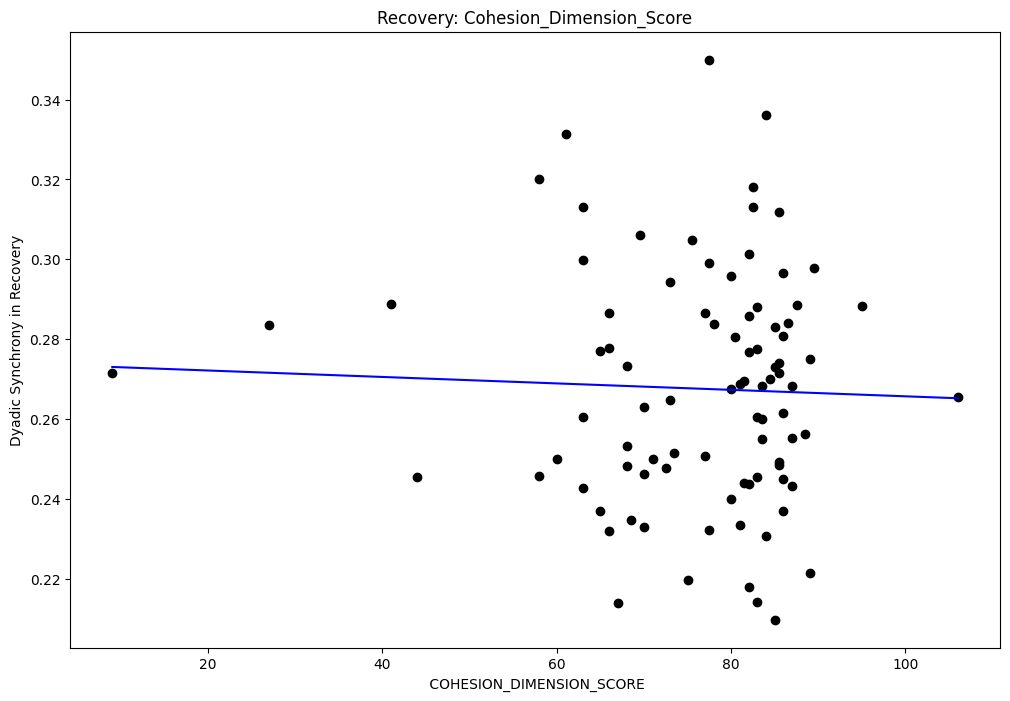

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.1272
Date:                Tue, 30 Apr 2024   Prob (F-statistic):              0.722
Time:                        14:39:41   Log-Likelihood:                 188.64
No. Observations:                  89   AIC:                            -373.3
Df Residuals:                      87   BIC:                            -368.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2738      0.018     15.617      0.0

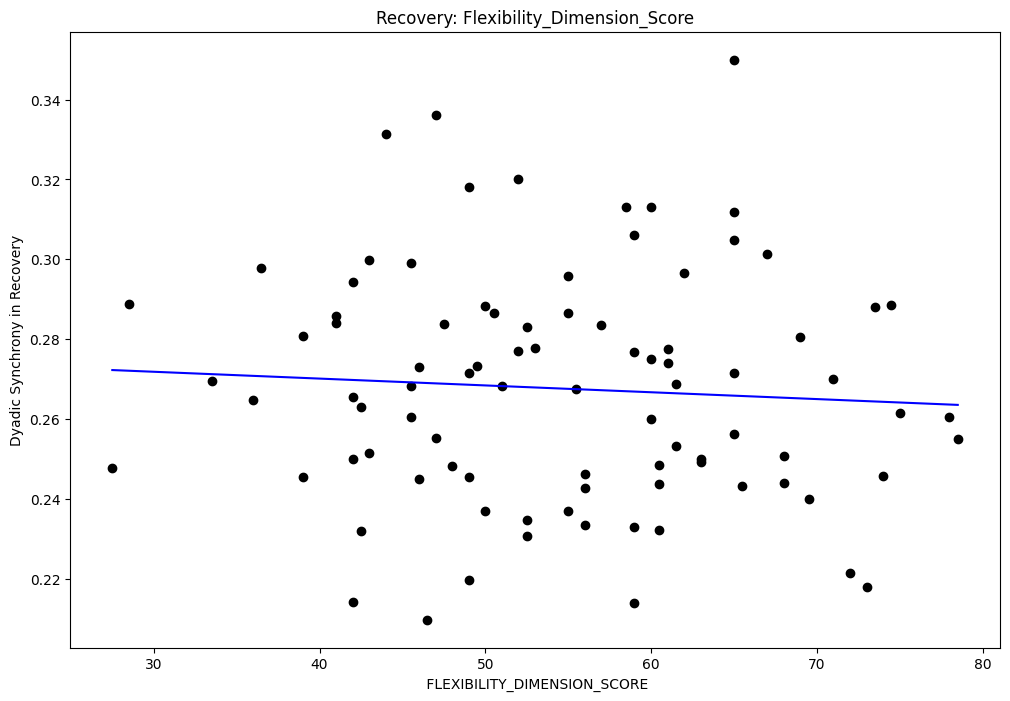

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3896
Date:                Tue, 30 Apr 2024   Prob (F-statistic):              0.534
Time:                        14:39:41   Log-Likelihood:                 188.77
No. Observations:                  89   AIC:                            -373.5
Df Residuals:                      87   BIC:                            -368.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2770      0.015     18.099      0.0

In [377]:
# this is because, in the sync_df, we need to have a way to differentiate between the parent and child. so subject names are, e.g.
# 1234p or 1234c. Whereas, in your .csv / dataframe for other variables of interest, they are not specific to a parent or child, but a family. 
# so we often combine these values by looping over the parents (top level values in sync_df that end in "p"), and then reference that name,
# with the "p" replaced by "" (nothing) to access the correct value in the dataframe. 

channels = [
#    'S3_D2 hbo', # left dlPFC
#    'S4_D2 hbo',
   'S5_D3 hbo', # right dlPFC
   'S6_D3 hbo',
#      'S1_D1 hbo', # left vlPFC
#      'S2_D1 hbo',
#      'S2_D2 hbo',
#      'S7_D3 hbo', # right vlPFC
#      'S7_D4 hbo',
#      'S8_D4 hbo'
]

#Set the Block of Interest here

block_num = 'Block 3'
block_name = 'Recovery'

# Set an identifier function for handling family id
# Use the difference in size of the ID's as a guide
sync_sample = list(sync_df.keys())[0]
scores_sample = scores.index[0]
identifier_diff =  len(scores_sample) - len(sync_sample) # Figure out how much smaller the scores sample is
score_identifier = lambda string : string[:identifier_diff]

# Variant 1 (individual block)
# ==================
# for all the parent / child pairs who are listed in the scores .csv / dataframe,
#    and averaging over all the channels that are uncommented above
#    so this will yield a list called "syncs" which is as long as the number of parent / child pairs 
#    that are found in both sync_df and the scores dataframe
#    i.e. 1 averaged WTC value per dyad, specifically derived from whichever block is named in 
#    "block_num" above.

syncs = []
sync_parents = []
for parent in list(sync_df.keys()):
    dyad_syncs = []
    child = parent.replace('p', 'c')
    if score_identifier(parent) in list(scores.index):
        for ch in channels:
            if ch not in bad_channels_dict[parent]:
                if ch not in bad_channels_dict[child]:
                    dyad_syncs.append(sync_df[parent][child][block_num][ch])
    if len(dyad_syncs) > 0:
        syncs.append(np.average(dyad_syncs))
        sync_parents.append(parent)
        
print(sync_parents)


# Variant 2 (block difference)
# ==================
# this version is doing the same thing, but specifically looking at the _difference_ of the WTC
#    in a dyad between two blocks. In this example, you can see that it is marking the difference
#    between sync of 'Block 2' and 'Block 1'. You are welcome to configure those variables 
#    as you see fit. The shape of the output list, syncs, will be the same as in Variant 1, and you
#    could use it just as well in any subsequent regressions, etc.  


# syncs = []
# sync_parents = []
# for parent in list(sync_df.keys()):
#    dyad_syncs = []
#    child = parent.replace('p', 'c')
#    if parent.replace('p', '') in list(scores.index):
#       for ch in channels:
#          if ch not in bad_channels_dict[parent]:
#             if ch not in bad_channels_dict[child]:
#                dyad_syncs.append(
#                   sync_df[parent][child]['Block 2'][ch] - \
#                   sync_df[parent][child]['Block 1'][ch])
#    if len(dyad_syncs) > 0:
#       syncs.append(np.average(dyad_syncs))
#       sync_parents.append(parent)


# Regression
# ================
# looping over the "columns of interest" which should be defined in a previous cell. as COIs = [ <stuff> ]
#     i.e., the names of any columns in your .csv you want to run regression on
for COI in COIs:

    # get the current variable of interest from the "scores" dataframe
    #    once again, only for subjects who are found in both the sync_df 
    #    and in the scores dataframe / .csv.
    voi = [scores.loc[[sub]][COI][0] for sub in [sub.replace('p', '') for sub in sync_parents]]
    
    # force the values read to be interpreted as float, as opposed to default string
    xnan = np.array(voi, dtype='float')
    ynan = np.array(syncs, dtype='float')

    # IQR correction if desired
#         # get IQR
#         q75, q25 = np.percentile(xnan, [75, 25])
#         intr_qr = q75 - q25
#         qmax = q75 + (1.5 * intr_qr)
#         qmin = q25 - (1.5 * intr_qr)
#         # remove the extra-IQR vals
#         xnan[xnan < qmin] = qmin
#         xnan[xnan > qmax] = qmin

    # remove any values that are NaN (hopefully none?) otherwise there
    #    may be issues in your .csv format 

    
    x = np.delete(xnan, np.where(np.isnan(xnan)))
    y = np.delete(ynan, np.where(np.isnan(xnan)))
    
    x = np.delete(x, np.where(np.isnan(y)))
    y = np.delete(y, np.where(np.isnan(y)))

    # Winsorize function (not recommended)
    # winsorize(y, inplace=True, limits=[0.05, 0.05])
    # winsorize(x, inplace=True, limits=[0.05, 0.05])

    # duplicate variables for use in regression (requires reshaping)
    X = x
    Y = y
    x = x.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    print(f"Coefficient of Determination: {r_sq}")
    print(f"intercept: {model.intercept_}")
    print(f"slope: {model.coef_}")

    # plot data
    plt.clf()
    plt.scatter(
        x,
        y,
        color='black')

    # plot regression line
    plt.plot(
        np.linspace(np.min(x), np.max(x)),
        model.predict(np.linspace(np.min(x), np.max(x)).reshape(-1, 1)),
        color='blue',
        linewidth=1.5)

    plt.xlabel(f" {COI.upper()}")
    plt.ylabel(f"Dyadic Synchrony in {block_name}")
    plt.title(f"{block_name}: {COI}")
    plt.show()
    X2 = sm.add_constant(X)
    est = sm.OLS(Y, X2)
    est2 = est.fit()
    print(est2.summary())

In [ ]:
#Older code to run group analysis for RDAS data (CAN STOP HERE UNLESS YOU NEED TO RUN GROUPS)

In [ ]:
# Differences in synchrony between the conflict and non-conflict group
group1syncs = [] # get synchrony from all of groups 1 (control)
group2syncs = [] # get synchrony from problem group

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
#     'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
    'S5_D3 hbo', # right frontal
#     'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
#     'S7_D3 hbo', #right temporal
#     'S7_D4 hbo',
#     'S8_D4 hbo'
]

for sub in sync_df.keys():
    avgsync = np.average([
        sync_df[sub][sub.replace('p', 'c')]['Block 2'][ch] for ch in channels])
    
    if (groups.loc[[sub.replace('p', '')]]['enroll_group'][0] == "Control") and \
        (groups.loc[[sub.replace('p', '')]]['rdas_group'][0] == "Non-Conflict"):
        group1syncs.append(avgsync)
    else:
        group2syncs.append(avgsync)
        
plt.clf()
plt.violinplot(
    [group1syncs, group2syncs],
    showmeans=True)
plt.show()

statistic, pvalue = ttest_ind(
    group1syncs,
    group2syncs)

print("T stat:", statistic, "\n", "P value:", pvalue)

In [ ]:
np.std(group2syncs)

In [ ]:
# enrollment group 2 OR above RDAS critical value == conflict group

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

In [ ]:
#configuration section that allows you to change which blocks, RDAS columns, and channels you want to include in subsequent analysis
blocks = {
    'Block 1': 'Pre-Play',
    'Block 2': 'Puzzle',
    'Block 3': 'Post-Play',
}

COIs = [
    'consensus',
    'satisfaction',
    'cohesion',
#     'total'
]

channels = [
#     'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
    'S5_D3 hbo', # right frontal
#     'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
#     'S7_D3 hbo', #right temporal
#     'S7_D4 hbo',
#     'S8_D4 hbo'
]